In [1]:
## # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 17.0 gigabytes of available RAM

Not using a high-RAM runtime


In [2]:
import os
import numpy as np
import pandas as pd

# !pip install tensorflow_addons
# ! pip install scikitplot
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.models import Model
# import tensorflow_addons as tfa

from sklearn.metrics import *
# import scikitplot as skplt

from functools import partial
import albumentations as A
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K

import numpy as np
import pandas as pd
import os
import itertools
import os, stat, time
from os.path import dirname as up
import shutil
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.layers import GlobalAveragePooling2D,GlobalAveragePooling1D
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D,Input
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from transformers import ViTFeatureExtractor, ViTModel

from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

['/device:GPU:0']

In [3]:
# # import glob, os
# # # os.chdir("archive")
# # paths =[]
# # for file in glob.glob("archive/10253/*.png"):
# #     paths.append(file)
# # paths
# import glob
# print(glob.glob("./archive/*"))

In [4]:
# import os

# arr = os.listdir()
# arr

In [14]:

# AUTOTUNE = tf.data.experimental.AUTOTUNE
data = pd.read_csv('./Folds.csv')
img_dir = './BreaKHis_v1/'
class_names = ['benign', 'malignant']
data = data.rename(columns={'filename':'path'})
data['label'] = data.path.apply(lambda x: x.split('/')[3])
data['label_int'] = data.label.apply(lambda x: class_names.index(x))
data['filename'] = data.path.apply(lambda x: x.split('/')[-1])
data
data = data.drop_duplicates(subset=['filename'],keep='first')[['label_int','filename','path']]
data['cl1'] = data.filename.apply(lambda x: x.split('_')[1])
data['cl2'] = data.filename.apply(lambda x: x.split('_')[2].split('-')[0])

print(data['path'].iloc[0])
data = data.sample(frac=1, random_state=42)
data.filename.apply(lambda x: x.split('_')[1]).value_counts()
data.filename.apply(lambda x: x.split('_')[2].split('-')[0]).value_counts().index

for ind,code  in enumerate (data.filename.apply(lambda x: x.split('_')[2].split('-')[0]).value_counts().index):
    print(code, str(ind))
    data['cl2'] = data['cl2'].str.replace(code,str(ind))

data

BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png
DC 0
F 1
MC 2
LC 3
TA 4
PC 5
PT 6
A 7


,label_int,filename,path,cl1,cl2
2815,1,SOB_M_DC-14-17901-100-008.png,BreaKHis_v1/histology_slides/breast/malignant/...,M,0
5532,0,SOB_B_PT-14-21998AB-100-006.png,BreaKHis_v1/histology_slides/breast/benign/SOB...,B,6
4553,1,SOB_M_MC-14-19979-100-018.png,BreaKHis_v1/histology_slides/breast/malignant/...,M,2
3438,1,SOB_M_DC-14-5694-200-006.png,BreaKHis_v1/histology_slides/breast/malignant/...,M,0
3023,1,SOB_M_DC-14-20629-400-011.png,BreaKHis_v1/histology_slides/breast/malignant/...,M,0
...,...,...,...,...,...
5226,0,SOB_B_F-14-21998CD-100-031.png,BreaKHis_v1/histology_slides/breast/benign/SOB...,B,1
5390,0,SOB_B_F-14-23222AB-400-008.png,BreaKHis_v1/histology_slides/breast/benign/SOB...,B,1
860,0,SOB_B_F-14-25197-400-058.png,BreaKHis_v1/histology_slides/breast/benign/SOB...,B,1
7603,1,SOB_M_MC-14-18842D-100-010.png,BreaKHis_v1/histology_slides/breast/malignant/...,M,2


Count of Benign    :  2480
Count of Malignant :  5429


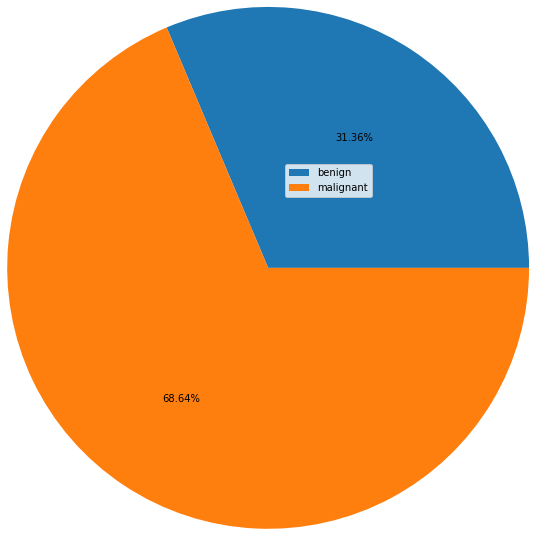

In [3]:
print('Count of Benign    : ', data[data.label_int == 0].label_int.count())
print('Count of Malignant : ', data[data.label_int == 1].label_int.count())
plt.pie([data[data.label_int == 0].label_int.count(),data[data.label_int == 1].label_int.count()],
        autopct = "%0.2f%%",radius=3)
plt.legend(loc = 'upper right', labels=['benign', 'malignant'])
# pie[0]

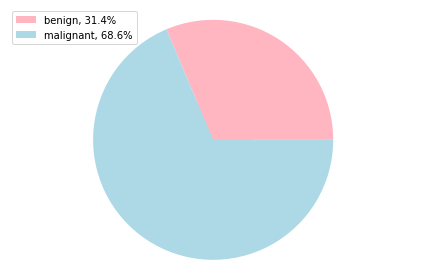

In [10]:


labels=['benign', 'malignant']
sizes = [x/len(data)*100 for x in [data[data.label_int == 0].label_int.count(),data[data.label_int == 1].label_int.count()]]
labels2 = [f'{l}, {s:0.1f}%' for l, s in zip(labels, sizes)]

colors=['#FFB6C1','#ADD8E6']
patches, texts = plt.pie(sizes, colors=colors)
plt.pie([data[data.label_int == 0].label_int.count(),data[data.label_int == 1].label_int.count()],
        radius=3,colors=colors)

plt.legend(patches, labels2, loc="best")
# # Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.tight_layout()
plt.savefig('2-classes.pdf')  

plt.show()


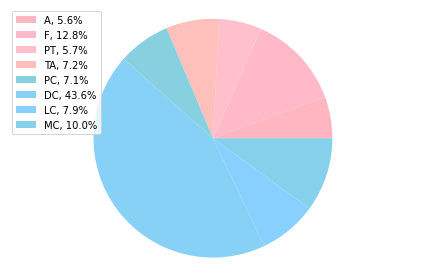

In [9]:
# DC 0# F 1# MC 2# LC 3# TA 4# PC 5# PT 6# A 7
# plt.pie([data[data.cl2 == '7'].cl2.count(),data[data.cl2 == '1'].cl2.count(),
#         data[data.cl2 == '6'].cl2.count(),data[data.cl2 == '4'].cl2.count(),
#         data[data.cl2 == '5'].cl2.count(),data[data.cl2 == '0'].cl2.count(),
#         data[data.cl2 == '3'].cl2.count(),data[data.cl2 == '2'].cl2.count(),
#         ],
#         colors=['#FFB6C1','#FFB9C9', '#FFC0CB', '#FFC0BB','#B0E0E6', '#ADD8E6','#87CEEB', '#87CEFA' ],
#         labels=['A','F','PT','TA','PC','DC','LC','MC'],
#         autopct = "%0.2f%%",
#         radius=3)





labels=['A','F','PT','TA','PC','DC','LC','MC']
sizes = [x/len(data)*100 for x in [data[data.cl2 == '7'].cl2.count(),data[data.cl2 == '1'].cl2.count(),
        data[data.cl2 == '6'].cl2.count(),data[data.cl2 == '4'].cl2.count(),
        data[data.cl2 == '5'].cl2.count(),data[data.cl2 == '0'].cl2.count(),
        data[data.cl2 == '3'].cl2.count(),data[data.cl2 == '2'].cl2.count(),
        ]]
labels2 = [f'{l}, {s:0.1f}%' for l, s in zip(labels, sizes)]

colors=['#FFB6C1','#FFB9C9', '#FFC0CB', '#FFC0BB','#87D0E0', '#87D0F6','#87D0FF', '#87D0EC' ]
patches, texts = plt.pie(sizes, colors=colors)
# plt.pie([data[data.label_int == 0].label_int.count(),data[data.label_int == 1].label_int.count()],
#         radius=3,colors=colors)

plt.legend(patches, labels2, loc="best")
# # Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.tight_layout()
plt.savefig('8-classes.pdf')  

plt.show()


In [7]:
# plt.savefig('8-class.pdf')  
plt.show()

./BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-037.png


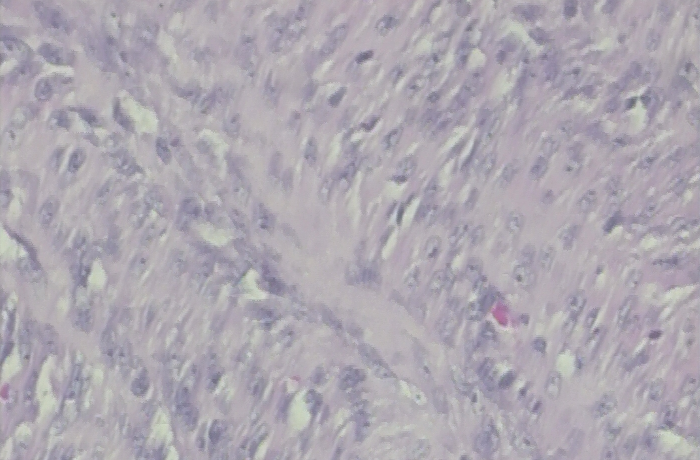

In [7]:
path =  './BreaKHis_v1/'+ data.path.iloc[0]
print(path)
load_img(path)



array([[[[198, 189, 216],
         [192, 188, 208],
         [191, 186, 206],
         ...,
         [179, 171, 198],
         [178, 170, 197],
         [178, 170, 197]],

        [[197, 189, 215],
         [190, 185, 206],
         [193, 189, 209],
         ...,
         [175, 165, 191],
         [175, 165, 191],
         [175, 165, 191]],

        [[197, 188, 214],
         [188, 177, 199],
         [187, 178, 199],
         ...,
         [164, 154, 173],
         [164, 150, 173],
         [164, 151, 174]],

        ...,

        [[160, 142, 164],
         [161, 145, 166],
         [163, 143, 164],
         ...,
         [160, 148, 160],
         [160, 149, 159],
         [160, 148, 159]],

        [[164, 148, 164],
         [165, 149, 165],
         [166, 151, 166],
         ...,
         [159, 146, 157],
         [160, 149, 158],
         [160, 148, 158]],

        [[167, 153, 167],
         [168, 154, 168],
         [169, 156, 170],
         ...,
         [159, 142, 156],
        

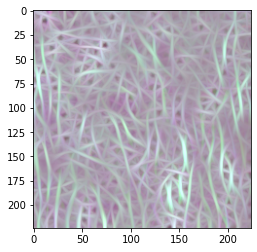

In [8]:
path =  './BreaKHis_v1/'+ data.path.iloc[1090]

img = cv2.imread(path)
img = cv2.resize(img, (224,224)) 

filters = []
ksize = 31
for theta in np.arange(0, np.pi, np.pi / 16):
    kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
    kern /= 1.5*kern.sum()
    filters.append(kern)


accum = np.zeros_like(img)
for kern in filters:
    fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
    np.maximum(accum, fimg, accum)

res1 = accum
plt.imshow(res1)
np.expand_dims(res1, axis=0)



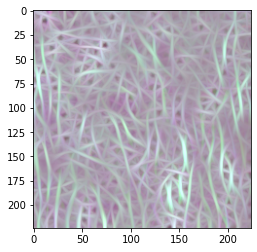

In [9]:
plt.imshow(res1)

In [10]:
img = cv2.imread(path)
print(type(img), img.shape)
img = load_img(path)
print(type(img))

<class 'numpy.ndarray'> (460, 700, 3)
<class 'PIL.PngImagePlugin.PngImageFile'>


In [11]:
# vit
import numpy as np
import keras

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
#         X = np.empty((self.batch_size, *self.dim, self.n_channels))
        X = np.empty((self.batch_size,*self.dim))#3,224,224))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
#             X[i,] =  np.load('./embeddings/vit/'+ str(ID) + '.npy') #np.load('data/' + ID + '.npy')
#             X[i,] =  np.load( (ID))

#             img = load_img(img_dir+'/'+ID , target_size=(224, 224))
            img = Image.open(img_dir+'/'+ID)

            img = feature_extractor(images=img, return_tensors="pt")
            X[i,] = img['pixel_values']


    
#             img = img_to_array(img,data_format='channels_first')
#             print(img.shape, (np.expand_dims(img, axis=0)).shape)
#             X[i,] = np.expand_dims(img, axis=0)



            # Store class
            y[i] = self.labels[ID]
#         print('X.shape', X.shape)
#         print('this is y: ', y, '\n',tf.keras.utils.to_categorical(y, num_classes=self.n_classes))
        return X,tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

import numpy as np

from keras.models import Sequential
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# from my_classes import DataGenerator

# Parameters

n_classes =8
params = {'dim': (3,224,224),#(3,224,224),# ( 1, 768),# ( 197, 768), #(32,32,32),
          'batch_size': 32,# 512,# 128,
          'n_classes': n_classes,#962,
#           'n_channels': 1,
          'shuffle': True}


partition={'train': list(data.path[:int(0.8*len(data))]),
           'validation': list(data.path[int(0.8*len(data)):])}
# labels = (data[['path','label_int']].set_index('path')).to_dict()['label_int']
labels = (data[['path','cl2']].set_index('path')).to_dict()['cl2']

# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

for x,y in validation_generator:
    print(x.shape, y.shape)
    break

(32, 3, 224, 224) (32, 8)


In [ ]:
#october
# vit
import numpy as np
import keras

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=16, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
#         X = np.empty((self.batch_size, *self.dim, self.n_channels))
        X = np.empty((self.batch_size,*self.dim))#3,224,224))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
#             X[i,] =  np.load('./embeddings/vit/'+ str(ID) + '.npy') #np.load('data/' + ID + '.npy')
#             X[i,] =  np.load( (ID))

#             img = load_img(img_dir+'/'+ID , target_size=(224, 224))
            img = Image.open(img_dir+'/'+ID)

            img = feature_extractor(images=img, return_tensors="pt")
            X[i,] = img['pixel_values']


    
#             img = img_to_array(img,data_format='channels_first')
#             print(img.shape, (np.expand_dims(img, axis=0)).shape)
#             X[i,] = np.expand_dims(img, axis=0)



            # Store class
            y[i] = self.labels[ID]
#         print('X.shape', X.shape)
#         print('this is y: ', y, '\n',tf.keras.utils.to_categorical(y, num_classes=self.n_classes))
        return X,tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

import numpy as np

from keras.models import Sequential
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# from my_classes import DataGenerator

# Parameters

n_classes =8
params = {'dim': (3,224,224),#(3,224,224),# ( 1, 768),# ( 197, 768), #(32,32,32),
          'batch_size': 32,# 512,# 128,
          'n_classes': n_classes,#962,
#           'n_channels': 1,
          'shuffle': True}


partition={'train': list(data.path[:int(0.8*len(data))]),
           'validation': list(data.path[int(0.8*len(data)):])}
# labels = (data[['path','label_int']].set_index('path')).to_dict()['label_int']
labels = (data[['path','cl2']].set_index('path')).to_dict()['cl2']

# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

for x,y in validation_generator:
    print(x.shape, y.shape)
    break

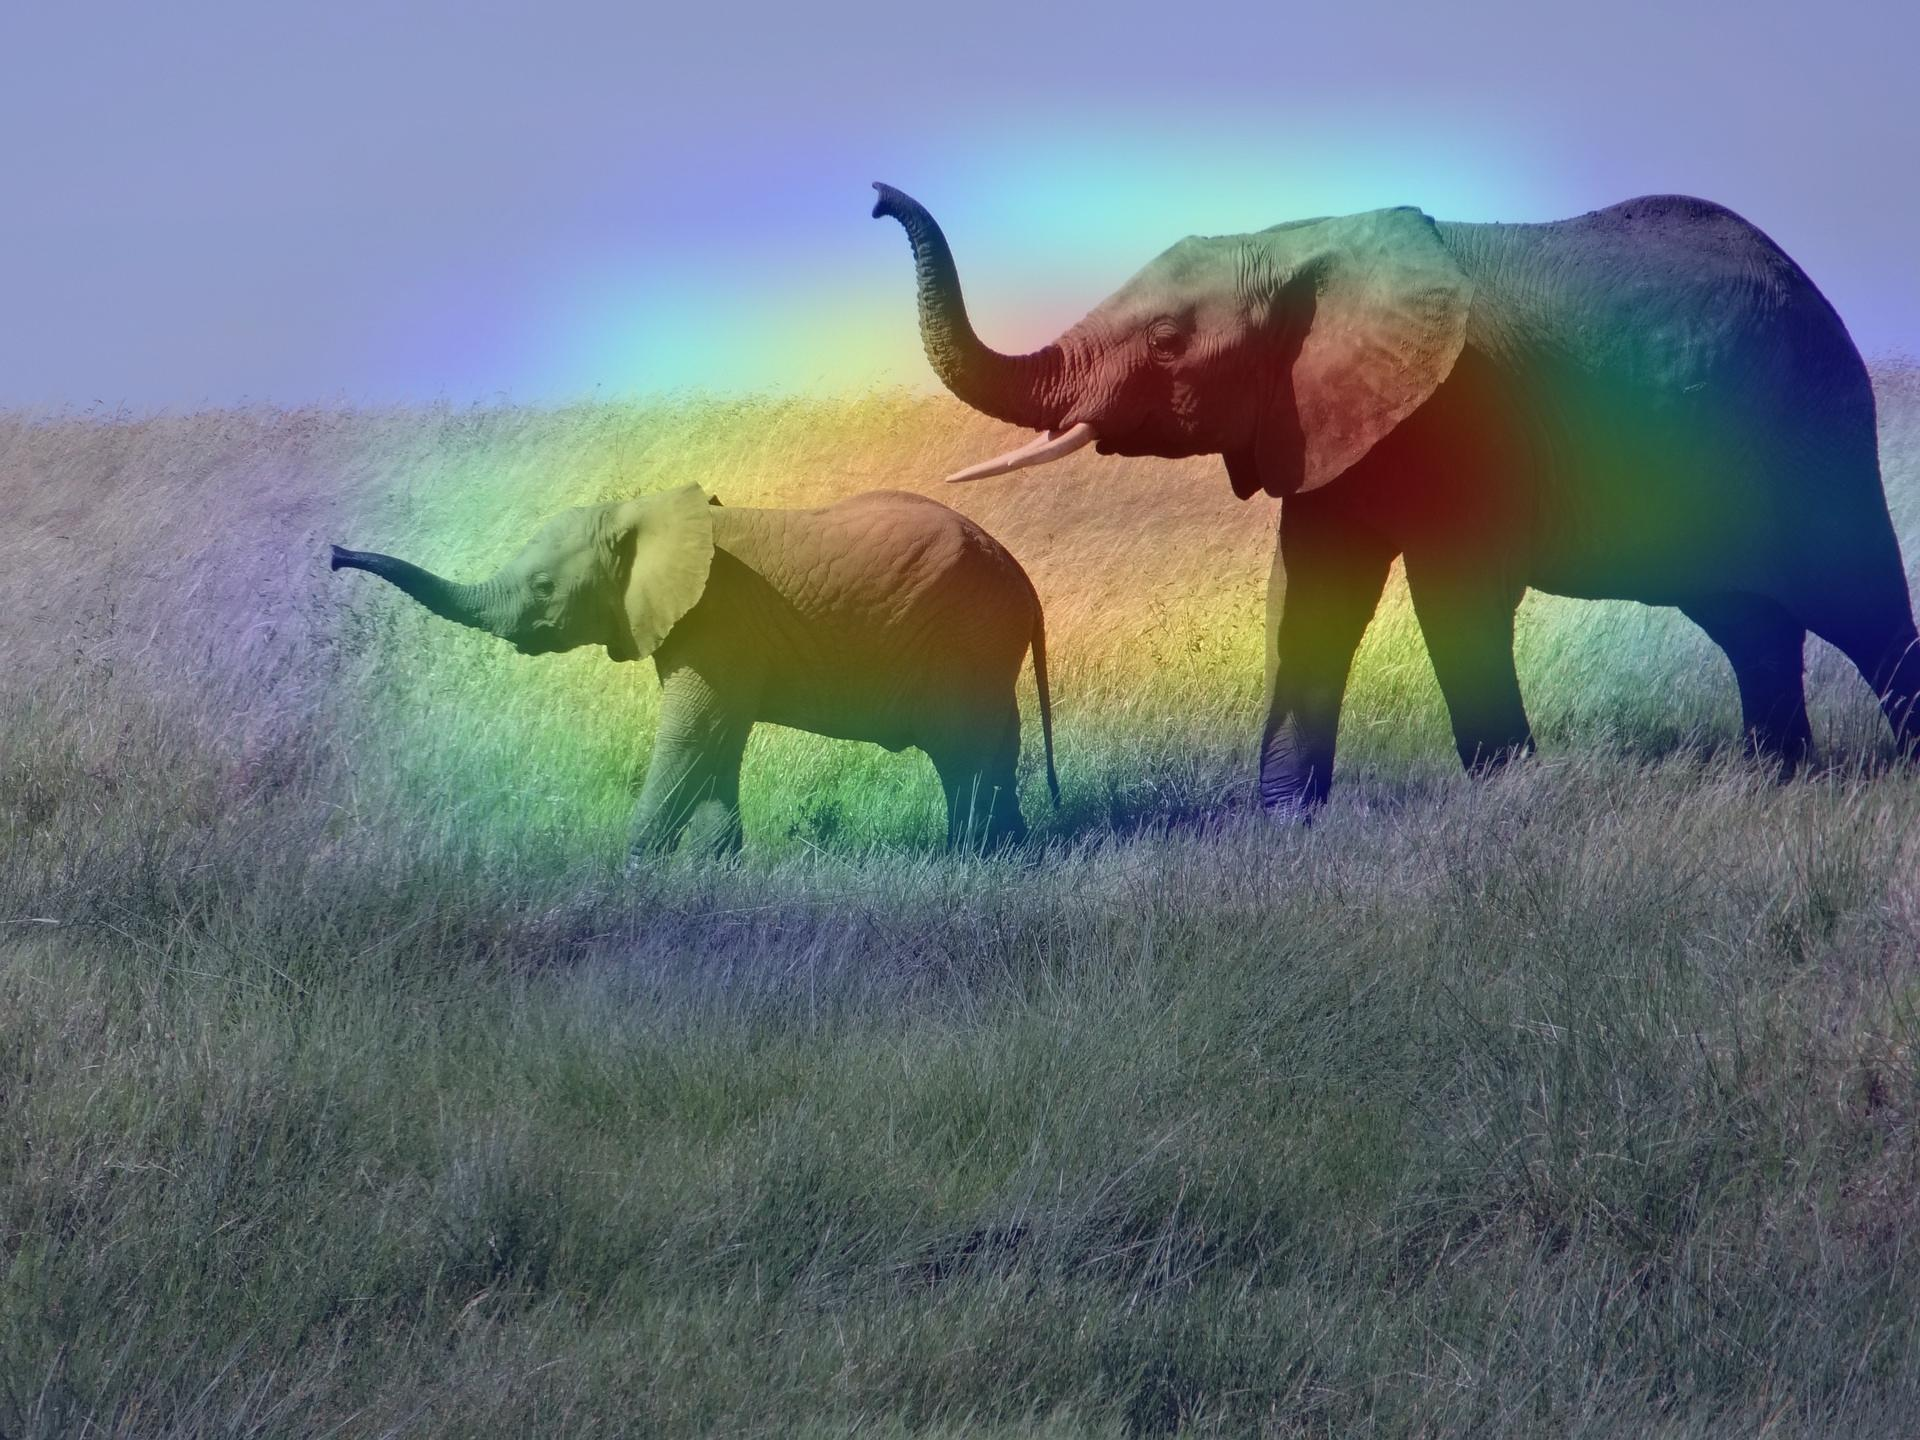

In [4]:
# visualization grad:

import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
img_path = keras.utils.get_file(
    "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
)

display(Image(img_path))



def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()





# Prepare image
# img_array = preprocess_input(get_img_array(img_path, size=img_size))

# # Make model
# model = model_builder(weights="imagenet")

# # Remove last layer's softmax
# model.layers[-1].activation = None

# # Print what the top predicted class is
# preds = model.predict(img_array)
# print("Predicted:", decode_predictions(preds, top=1)[0])

# # Generate class activation heatmap
# heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# # Display heatmap
# plt.matshow(heatmap)
# plt.show()


def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

In [49]:
# # visualization grad:

# # import numpy as np
# # import tensorflow as tf
# # from tensorflow import keras

# # # Display
# # from IPython.display import Image, display
# # import matplotlib.pyplot as plt
# # import matplotlib.cm as cm
# from transformers import ViTFeatureExtractor, ViTModel
# import tensorflow as tf
# from transformers import TFViTModel



# feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
# base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
# base_model.trainable = False


# model_builder = keras.applications.xception.Xception
# img_size = (299, 299)
# preprocess_input = keras.applications.xception.preprocess_input
# decode_predictions = keras.applications.xception.decode_predictions

# last_conv_layer_name = "block14_sepconv2_act"

# # The local path to our target image
# img_path = keras.utils.get_file(
#     "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
# )

# display(Image(img_path))



# def get_img_array(img_path, size):
#     # `img` is a PIL image of size 299x299
#     img = keras.preprocessing.image.load_img(img_path, target_size=size)
#     # `array` is a float32 Numpy array of shape (299, 299, 3)
#     array = keras.preprocessing.image.img_to_array(img)
#     # We add a dimension to transform our array into a "batch"
#     # of size (1, 299, 299, 3)
#     array = np.expand_dims(array, axis=0)
#     return array


# def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
#     # First, we create a model that maps the input image to the activations
#     # of the last conv layer as well as the output predictions
#     grad_model = tf.keras.models.Model(
#         [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
#     )

#     # Then, we compute the gradient of the top predicted class for our input image
#     # with respect to the activations of the last conv layer
#     with tf.GradientTape() as tape:
#         last_conv_layer_output, preds = grad_model(img_array)
#         if pred_index is None:
#             pred_index = tf.argmax(preds[0])
#         class_channel = preds[:, pred_index]

#     # This is the gradient of the output neuron (top predicted or chosen)
#     # with regard to the output feature map of the last conv layer
#     grads = tape.gradient(class_channel, last_conv_layer_output)

#     # This is a vector where each entry is the mean intensity of the gradient
#     # over a specific feature map channel
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

#     # We multiply each channel in the feature map array
#     # by "how important this channel is" with regard to the top predicted class
#     # then sum all the channels to obtain the heatmap class activation
#     last_conv_layer_output = last_conv_layer_output[0]
#     heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
#     heatmap = tf.squeeze(heatmap)

#     # For visualization purpose, we will also normalize the heatmap between 0 & 1
#     heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
#     return heatmap.numpy()





# # Prepare image
# img_array = preprocess_input(get_img_array(img_path, size=img_size))

# # Make model
# model = model_builder(weights="imagenet")

# # Remove last layer's softmax
# model.layers[-1].activation = None

# # Print what the top predicted class is
# preds = model.predict(img_array)
# print("Predicted:", decode_predictions(preds, top=1)[0])

# # Generate class activation heatmap
# heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# # Display heatmap
# plt.matshow(heatmap)
# plt.show()


# # def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
# #     # Load the original image
# #     img = keras.preprocessing.image.load_img(img_path)
# #     img = keras.preprocessing.image.img_to_array(img)

# #     # Rescale heatmap to a range 0-255
# #     heatmap = np.uint8(255 * heatmap)

# #     # Use jet colormap to colorize heatmap
# #     jet = cm.get_cmap("jet")

# #     # Use RGB values of the colormap
# #     jet_colors = jet(np.arange(256))[:, :3]
# #     jet_heatmap = jet_colors[heatmap]

# #     # Create an image with RGB colorized heatmap
# #     jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
# #     jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
# #     jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# #     # Superimpose the heatmap on original image
# #     superimposed_img = jet_heatmap * alpha + img
# #     superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# #     # Save the superimposed image
# #     superimposed_img.save(cam_path)

# #     # Display Grad CAM
# #     display(Image(cam_path))


# # save_and_display_gradcam(img_path, heatmap)

In [12]:
# y = list(labels.values())
# y
# tf.keras.utils.to_categorical(y, num_classes=8)

In [13]:
# data

In [ ]:
from transformers import ViTFeatureExtractor, ViTModel
import tensorflow as tf
from transformers import TFViTModel

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
# model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
base_model.trainable = False


pixel_values = tf.keras.layers.Input(shape=(3, 224,224)
                                     , name='pixel_values', dtype='float32')


# vit = base_model(pixel_values)[0]
vit = base_model.vit(pixel_values)[0]
# classifier = tf.keras.layers.Dense(1 , activation='sigmoid', name='outputs')(vit[:, 0, :])
vit = GlobalAveragePooling1D()(vit)
# vit = tf.keras.layers.Dense(128 , activation='relu')(vit)
# classifier = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(vit)
# classifier = tf.keras.layers.Dense(2, activation='softmax', name='outputs')(vit)
classifier = tf.keras.layers.Dense(n_classes, activation='softmax', name='outputs')(vit)


model = tf.keras.Model(inputs=pixel_values, outputs=classifier)
print(model.summary())



# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)


# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.7)
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

# model.compile(
#     optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
# history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 15, batch_size = 32)
# history = model.fit(train, validation_data=valid, validation_data = (x_test, y_test), epochs = 15, batch_size = 32)

opt = SGD(lr=0.01, momentum=0.9)
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# from keras.optimizers import SGD
# opt = SGD(lr=0.01)
# model.compile(loss = "categorical_crossentropy", optimizer = opt)

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

# model.compile(optimizer=opt, loss='binary_crossentropy',metrics=METRICS)#'Adam'
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'

# from sklearn.utils import compute_class_weight
# classWeight = compute_class_weight('balanced',[0,1] , j['tagencode']) 
# classWeight = dict(enumerate(classWeight))
history = model.fit(training_generator, validation_data=validation_generator, epochs = 400)#,class_weight=classWeight)#, batch_size = 32)



All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pixel_values (InputLayer)   [(None, 3, 224, 224)]     0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPoo  86389248  
                             ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 global_average_pooling1d (G  (None, 768)              0         
 lobalAveragePooling1D)                                          
                                                             

C:\Users\mesla\PycharmProjects\breast_cancer_detection\venv\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/400
 17/197 [=>............................] - ETA: 4:50 - loss: 1.9265 - accuracy: 0.8702 - precision: 0.4371 - recall: 0.1342 - auc: 0.6470 - f1_score: 0.1418  

In [ ]:

4/2

In [143]:
from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
inputs = feature_extractor(images=image, return_tensors="pt")

outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state
last_hidden_states.shape

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

torch.Size([1, 197, 768])

In [ ]:
model.save('vit.h5')

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model f1_score')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## CNN

In [ ]:
# import numpy as np
# import keras

# class DataGenerator(tf.keras.utils.Sequence):
#     'Generates data for Keras'
#     def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
#                  n_classes=10, shuffle=True,filters=None):
#         'Initialization'
#         self.dim = dim
#         self.batch_size = batch_size
#         self.labels = labels
#         self.list_IDs = list_IDs
#         self.n_channels = n_channels
#         self.n_classes = n_classes
#         self.shuffle = shuffle
#         self.on_epoch_end()
#         self.filters = filters

#     def __len__(self):
#         'Denotes the number of batches per epoch'
#         return int(np.floor(len(self.list_IDs) / self.batch_size))

#     def __getitem__(self, index):
#         'Generate one batch of data'
#         # Generate indexes of the batch
#         indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

#         # Find list of IDs
#         list_IDs_temp = [self.list_IDs[k] for k in indexes]

#         # Generate data
#         X, y = self.__data_generation(list_IDs_temp)

#         return X, y

#     def on_epoch_end(self):
#         'Updates indexes after each epoch'
#         self.indexes = np.arange(len(self.list_IDs))
#         if self.shuffle == True:
#             np.random.shuffle(self.indexes)

#     def __data_augmentation(self, img):
#         ''' function for apply some data augmentation '''
# #         img = tf.keras.preprocessing.image.random_shift(img, 0.2, 0.3)
#         img = tf.image.random_flip_left_right(img)
#         img = tf.image.random_flip_up_down(img)
# #         img = tf.keras.preprocessing.image.random_rotation(img,90)
# #         img = tf.keras.preprocessing.image.random_zoom(img,(0.5,0.5))
        
#         return img

#     def __data_generation(self, list_IDs_temp):
#         'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
#         # Initialization
#         X = np.empty((self.batch_size,*self.dim))#3,224,224))
#         y = np.empty((self.batch_size), dtype=int)

#         # Generate data
#         for i, ID in enumerate(list_IDs_temp):

            
# #             img = load_img(img_dir+'/'+ID , target_size=(224, 224))
            
    
#             #gabor filter
#             img = cv2.imread(img_dir+'/'+ID )
#             img = cv2.resize(img, (224,224)) 
# #             filters = []
# #             ksize = 31
# #             for theta in np.arange(0, np.pi, np.pi / 16):
# #                 kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
# #                 kern /= 1.5*kern.sum()
# #                 filters.append(kern)

#             accum = np.zeros_like(img)
#             for kern in self.filters:
#                 fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
#                 np.maximum(accum, fimg, accum)
#             img = accum

            
# #             img = img_to_array(img)#,data_format='channels_first')
#             img = tf.keras.applications.densenet.preprocess_input(img)
#             img = self.__data_augmentation(img)

#             X[i,] = np.expand_dims(img, axis=0)

#             y[i] = self.labels[ID]
#         return X,tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

# import numpy as np

# from keras.models import Sequential
# # from my_classes import DataGenerator

# # Parameters

# n_classes =8
# filters = []
# ksize = 31
# for theta in np.arange(0, np.pi, np.pi / 16):
#     kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
#     kern /= 1.5*kern.sum()
#     filters.append(kern)

# params = {'dim': (224,224,3),#(3,224,224),# ( 1, 768),# ( 197, 768), #(32,32,32),
#           'batch_size': 32,# 512,# 128,
#           'n_classes': n_classes,#962,
# #           'n_channels': 1,
#           'shuffle': True,
#          'filters':filters}


# partition={'train': list(data.path[:int(0.8*len(data))]),
#            'validation': list(data.path[int(0.8*len(data)):])}
# # labels = (data[['path','label_int']].set_index('path')).to_dict()['label_int']
# labels = (data[['path','cl2']].set_index('path')).to_dict()['cl2']
# # data['2l'] = list(map(list,(data[['cl2', 'label_int']]).values))
# # data
# # labels = (data[['path','2l']].set_index('path')).to_dict()['2l']
# # labels

# # Generators
# training_generator = DataGenerator(partition['train'], labels, **params)
# validation_generator = DataGenerator(partition['validation'], labels, **params)

# for ind,row in validation_generator:
#     print(ind.shape,row.shape)
#     break

In [ ]:
# # two output
# import numpy as np
# import keras

# class DataGenerator(tf.keras.utils.Sequence):
#     'Generates data for Keras'
#     def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
#                  n_classes=10, shuffle=True):
#         'Initialization'
#         self.dim = dim
#         self.batch_size = batch_size
#         self.labels = labels
#         self.list_IDs = list_IDs
#         self.n_channels = n_channels
#         self.n_classes = n_classes
#         self.shuffle = shuffle
#         self.on_epoch_end()

#     def __len__(self):
#         'Denotes the number of batches per epoch'
#         return int(np.floor(len(self.list_IDs) / self.batch_size))

#     def __getitem__(self, index):
#         'Generate one batch of data'
#         # Generate indexes of the batch
#         indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

#         # Find list of IDs
#         list_IDs_temp = [self.list_IDs[k] for k in indexes]

#         # Generate data
#         X, y = self.__data_generation(list_IDs_temp)

#         return X, y

#     def on_epoch_end(self):
#         'Updates indexes after each epoch'
#         self.indexes = np.arange(len(self.list_IDs))
#         if self.shuffle == True:
#             np.random.shuffle(self.indexes)

#     def __data_generation(self, list_IDs_temp):
#         'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
#         # Initialization
# #         X = np.empty((self.batch_size, *self.dim, self.n_channels))
#         X = np.empty((self.batch_size,*self.dim))#3,224,224))
# #         y = np.empty((self.batch_size), dtype=int)
#         y = np.empty((self.batch_size,2), dtype=int)

#         # Generate data
#         for i, ID in enumerate(list_IDs_temp):
#             # Store sample
# #             X[i,] =  np.load('./embeddings/vit/'+ str(ID) + '.npy') #np.load('data/' + ID + '.npy')
# #             X[i,] =  np.load( (ID))

#             img = load_img(img_dir+'/'+ID , target_size=(224, 224))
#             img = img_to_array(img)#,data_format='channels_first')
#             X[i,] = np.expand_dims(img, axis=0)



#             # Store class
# #             y[i] = self.labels[ID]
#             y1 = self.labels[ID][0]
#             y1 = tf.keras.utils.to_categorical(y1, num_classes=self.n_classes)
#             y2 = self.labels[ID][1]
# #             y2 = tf.keras.utils.to_categorical(y2, num_classes=2)
# #             y[i,]=[y1,y2]
#             y[i,] = np.expand_dims(np.array([y1,y2]), axis=0)

#             print("this is y: ", y)
        
# #         print('X.shape', X.shape)
# #         print('this is y: ', y, '\n',tf.keras.utils.to_categorical(y, num_classes=self.n_classes))
#         return X,y#tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

# import numpy as np

# from keras.models import Sequential
# # from my_classes import DataGenerator

# # Parameters

# n_classes =8
# params = {'dim': (224,224,3),#(3,224,224),# ( 1, 768),# ( 197, 768), #(32,32,32),
#           'batch_size': 128,# 512,# 128,
#           'n_classes': n_classes,#962,
# #           'n_channels': 1,
#           'shuffle': True}


# partition={'train': list(data.path[:int(0.8*len(data))]),
#            'validation': list(data.path[int(0.8*len(data)):])}
# # labels = (data[['path','label_int']].set_index('path')).to_dict()['label_int']
# # labels = (data[['path','cl2']].set_index('path')).to_dict()['cl2']
# data['2l'] = list(map(list,(data[['cl2', 'label_int']]).values))
# data
# labels = (data[['path','2l']].set_index('path')).to_dict()['2l']
# labels

# # Generators
# training_generator = DataGenerator(partition['train'], labels, **params)
# validation_generator = DataGenerator(partition['validation'], labels, **params)


In [ ]:
# # #  list(data.path[int(0.8*len(data)):])
# # # len(labels), len(list(data.path[:int(0.8*len(data))])) , len(list(data.path[int(0.8*len(data)):]))
# # labels = (data[['path','cl2']].set_index('path')).to_dict()['cl2']
# # labels
# # (data[['path','cl2', 'label_int']]#.set_index('path'))#.to_dict().keys()


# data['2l'] = list(map(list,(data[['cl2', 'label_int']]).values))
# data
# labels = (data[['path','2l']].set_index('path')).to_dict()['2l']
# labels['BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png']

In [ ]:
# model=Sequential()

# model.add(Input(shape=(224,224,3)))
# model.add(Conv2D(filters=64,kernel_size=(4,4),activation='relu'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))
# model.add(Conv2D(filters=32,kernel_size=(4,4),activation='relu'))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(1024,activation='relu'))
# # model.add(Dense(1,activation='sigmoid'))
# model.add(Dense(n_classes, activation='softmax'))
# # model.compile(loss = 'binary_crossentropy', optimizer ='adam', metrics= ['accuracy'])

# model.summary()


# def f1_score(y_true, y_pred): #taken from old keras source code
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     recall = true_positives / (possible_positives + K.epsilon())
#     f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
#     return f1_val
# METRICS = [
#       tf.keras.metrics.BinaryAccuracy(name='accuracy'),
#       tf.keras.metrics.Precision(name='precision'),
#       tf.keras.metrics.Recall(name='recall'),  
#       tf.keras.metrics.AUC(name='auc'),
#         f1_score,
# ]

# # model.compile(optimizer=opt, loss='binary_crossentropy',metrics=METRICS)#'Adam'
# model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'


# # from sklearn.utils import compute_class_weight
# # classWeight = compute_class_weight('balanced',[0,1] , j['tagencode']) 
# # classWeight = dict(enumerate(classWeight))
# history = model.fit(training_generator, validation_data=validation_generator, epochs = 10)#,class_weight=classWeight)#, batch_size = 32)



In [ ]:
# basemodel.summary()

In [ ]:
# basemodel = tf.keras.applications.DenseNet169(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(224, 224, 3),
#     pooling = 'avg')
# basemodel.trainable = False

# model=Sequential()
# # model.add(Input(shape=(224,224,3)))
# model.add(basemodel)
# # model.add()
# # model.add(Flatten())

# model.add(Dropout(0.25))
# model.add(Dense(1024,activation='relu'))
# # model.add(Dense(1,activation='sigmoid'))
# model.add(Dense(n_classes, activation='softmax'))

# # model.compile(loss = 'binary_crossentropy', optimizer ='adam', metrics= ['accuracy'])

# model.summary()


# def f1_score(y_true, y_pred): #taken from old keras source code
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     recall = true_positives / (possible_positives + K.epsilon())
#     f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
#     return f1_val
# METRICS = [
#       tf.keras.metrics.BinaryAccuracy(name='accuracy'),
#       tf.keras.metrics.Precision(name='precision'),
#       tf.keras.metrics.Recall(name='recall'),  
#       tf.keras.metrics.AUC(name='auc'),
#         f1_score,
# ]
# opt = SGD(lr=0.01, momentum=0.9)

# # model.compile(optimizer=opt, loss='binary_crossentropy',metrics=METRICS)#'Adam'
# model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'


# # from sklearn.utils import compute_class_weight
# # classWeight = compute_class_weight('balanced',[0,1] , j['tagencode']) 
# # classWeight = dict(enumerate(classWeight))
# history = model.fit(training_generator, validation_data=validation_generator, epochs = 10)#,class_weight=classWeight)#, batch_size = 32)



In [ ]:
# # with pre processing 
# basemodel = tf.keras.applications.DenseNet169(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(224, 224, 3),
#     pooling = 'avg')
# basemodel.trainable = False

# model=Sequential()
# # model.add(Input(shape=(224,224,3)))
# # model.add()
# model.add(basemodel)
# model.add(Flatten())
# model.add(tf.keras.layers.BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(1024,activation='relu',kernel_initializer= tf.keras.initializers.he_normal(seed=32)))
# model.add(tf.keras.layers.BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Dense(1024,activation='relu',kernel_initializer= tf.keras.initializers.he_normal(seed=32)))
# model.add(Dense(n_classes, activation='softmax',kernel_initializer= tf.keras.initializers.he_normal(seed=32)))
# model.summary()


# def f1_score(y_true, y_pred): #taken from old keras source code
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     recall = true_positives / (possible_positives + K.epsilon())
#     f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
#     return f1_val
# METRICS = [
#       tf.keras.metrics.BinaryAccuracy(name='accuracy'),
#       tf.keras.metrics.Precision(name='precision'),
#       tf.keras.metrics.Recall(name='recall'),  
#       tf.keras.metrics.AUC(name='auc'),
#         f1_score,
# ]
# opt = SGD(lr=0.01, momentum=0.9)

# # model.compile(optimizer=opt, loss='binary_crossentropy',metrics=METRICS)#'Adam'
# model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'


# # from sklearn.utils import compute_class_weight
# # classWeight = compute_class_weight('balanced',[0,1] , j['tagencode']) 
# # classWeight = dict(enumerate(classWeight))
# history = model.fit(training_generator, validation_data=validation_generator, epochs = 10)#,class_weight=classWeight)#, batch_size = 32)



In [ ]:
# # with augmentation

# # with pre processing 
# basemodel = tf.keras.applications.DenseNet169(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(224, 224, 3),
#     pooling = 'avg')
# basemodel.trainable = False

# model=Sequential()
# # model.add(Input(shape=(224,224,3)))
# # model.add()
# model.add(basemodel)
# model.add(Flatten())
# model.add(tf.keras.layers.BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.25))


# model.add(Dense(1024,activation='relu',kernel_initializer= tf.keras.initializers.he_normal(seed=32)))
# model.add(Dense(n_classes, activation='softmax',kernel_initializer= tf.keras.initializers.he_normal(seed=32)))
# model.summary()


# def f1_score(y_true, y_pred): #taken from old keras source code
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     recall = true_positives / (possible_positives + K.epsilon())
#     f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
#     return f1_val
# METRICS = [
#       tf.keras.metrics.BinaryAccuracy(name='accuracy'),
#       tf.keras.metrics.Precision(name='precision'),
#       tf.keras.metrics.Recall(name='recall'),  
#       tf.keras.metrics.AUC(name='auc'),
#         f1_score,
# ]
# opt = SGD(lr=0.01, momentum=0.9)
# opt = tf.keras.optimizers.Adam(lr=0.001)

# # model.compile(optimizer=opt, loss='binary_crossentropy',metrics=METRICS)#'Adam'
# model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'


# history = model.fit(training_generator, validation_data=validation_generator, epochs = 10)#,class_weight=classWeight)#, batch_size = 32)


In [ ]:
# # batch size 32:
# # with augmentation

# # with pre processing 
# basemodel = tf.keras.applications.DenseNet169(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(224, 224, 3),
#     pooling = 'avg')
# basemodel.trainable = False

# model=Sequential()
# # model.add(Input(shape=(224,224,3)))
# # model.add()
# model.add(basemodel)
# model.add(Flatten())
# model.add(tf.keras.layers.BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.25))


# model.add(Dense(1024,activation='relu',kernel_initializer= tf.keras.initializers.he_normal(seed=32)))
# model.add(Dense(n_classes, activation='softmax',kernel_initializer= tf.keras.initializers.he_normal(seed=32)))
# model.summary()


# def f1_score(y_true, y_pred): #taken from old keras source code
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     recall = true_positives / (possible_positives + K.epsilon())
#     f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
#     return f1_val
# METRICS = [
#       tf.keras.metrics.BinaryAccuracy(name='accuracy'),
#       tf.keras.metrics.Precision(name='precision'),
#       tf.keras.metrics.Recall(name='recall'),  
#       tf.keras.metrics.AUC(name='auc'),
#         f1_score,
# ]
# opt = SGD(lr=0.01, momentum=0.9)
# opt = tf.keras.optimizers.Adam(lr=0.001)

# # model.compile(optimizer=opt, loss='binary_crossentropy',metrics=METRICS)#'Adam'
# model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'


# history = model.fit(training_generator, validation_data=validation_generator, epochs = 10)#,class_weight=classWeight)#, batch_size = 32)


In [ ]:
# Ypred = model.predict(xtest)

# Ypred = np.argmax(Ypred, axis=1)
# Ytrue = np.argmax(ytest, axis=1)

# cm = confusion_matrix(Ytrue, Ypred)
# plt.figure(figsize=(12, 12))
# ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
# ax.set_ylabel('Actual', fontsize=20)
# ax.set_xlabel('Predicted', fontsize=20)

In [ ]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

# plt.plot(history.history['recall'])
# plt.plot(history.history['val_recall'])
# plt.title('model recall')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()
# plt.plot(history.history['precision'])
# plt.plot(history.history['val_precision'])
# plt.title('model precision')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()
# plt.plot(history.history['auc'])
# plt.plot(history.history['val_auc'])
# plt.title('model auc')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()
# plt.plot(history.history['f1_score'])
# plt.plot(history.history['val_f1_score'])
# plt.title('model f1_score')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

In [ ]:
## multi output

In [ ]:
# basemodel = tf.keras.applications.DenseNet169(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(224, 224, 3),
#     pooling = 'avg')
# basemodel.trainable = False


# inputs = tf.keras.Input(shape=(224, 224, 3))
# x = basemodel(inputs)
# x = Dropout(0.25)(x)
# x = Dense(1024,activation='relu')(x)
# output1 = Dense(n_classes,name='8classes', activation='softmax')(x)
# output2 = Dense(2,name='2classes', activation='softmax')(x)


# model = tf.keras.Model(inputs=inputs, outputs=[output1,output2])

# model.summary()


# def f1_score(y_true, y_pred): #taken from old keras source code
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     recall = true_positives / (possible_positives + K.epsilon())
#     f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
#     return f1_val
# METRICS = [
#       tf.keras.metrics.BinaryAccuracy(name='accuracy'),
#       tf.keras.metrics.Precision(name='precision'),
#       tf.keras.metrics.Recall(name='recall'),  
#       tf.keras.metrics.AUC(name='auc'),
#         f1_score,
# ]
# opt = SGD(learning_rate=0.01, momentum=0.9)
# model.compile(optimizer=opt, loss={'8classes':'categorical_crossentropy',
#                                   '2classes':'categorical_crossentropy'},metrics=METRICS)#'Adam'
# tf.keras.utils.plot_model(model, "my_first_model.png")

# history = model.fit(training_generator, validation_data=validation_generator, epochs = 10)#,class_weight=classWeight)#, batch_size = 32)



In [ ]:
# basemodel = tf.keras.applications.DenseNet169(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(224, 224, 3),
#     pooling = 'avg')
# basemodel.trainable = False
# base_vecs = basemodel.predict(validation_generator)
# l = ((list(labels.values())[int(0.8*len(data)):])[:len(base_vecs)])
# base_vecs.shape, len(l)

In [ ]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif
# from sklearn.ensemble import GradientBoostingClassifier
# # evaluate xgboost algorithm for classification
# from numpy import mean
# from numpy import std
# from sklearn.datasets import make_classification
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from xgboost import XGBClassifier


In [ ]:

# fvalue_Best = SelectKBest(f_classif, k=512)
# X_kbest = fvalue_Best.fit_transform(base_vecs, l)
# print(X_kbest)

# print('Original number of features:', base_vecs.shape)
# print('Reduced number of features:', X_kbest.shape)


# model = XGBClassifier(n_estimators=100, max_depth=8, n_jobs=-1, eval_metric='auc', seed=42)#,verbosity =1)
# model.fit(X_kbest, l)
# # n_scores = cross_val_score(model,X_kbest, l, scoring='accuracy', n_jobs=-1)
# # print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


# # n_scores = cross_val_score(model,X_kbest, l, scoring='f1_macro', n_jobs=-1)
# # print('f1_macro: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))



In [ ]:
# n_scores = cross_val_score(model,X_kbest, l, scoring='accuracy', n_jobs=-1)
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))



In [ ]:

# n_scores = cross_val_score(model,X_kbest, l, scoring='f1_macro', n_jobs=-1)
# print('f1_macro: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))



In [ ]:
# fvalue_Best = SelectKBest(f_classif, k=256)
# X_kbest = fvalue_Best.fit_transform(base_vecs, l)
# # print(X_kbest)

# print('Original number of features:', base_vecs.shape)
# print('Reduced number of features:', X_kbest.shape)


# model = XGBClassifier(n_estimators=100, max_depth=8, n_jobs=-1, eval_metric='auc', seed=42)#,verbosity =1)
# model.fit(X_kbest, l)
# # n_scores = cross_val_score(model,X_kbest, l, scoring='accuracy', n_jobs=-1)
# # print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

# # n_scores = cross_val_score(model,X_kbest, l, scoring='f1_macro', n_jobs=-1)
# # print('f1_macro: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


In [ ]:
# n_scores = cross_val_score(model,X_kbest, l, scoring='accuracy', n_jobs=-1)
# print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))



In [ ]:
# n_scores = cross_val_score(model,X_kbest, l, scoring='f1_macro', n_jobs=-1)
# print('f1_macro: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


<BarContainer object of 7 artists>

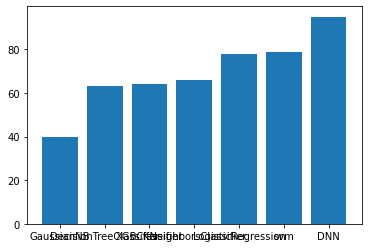

In [3]:
classifiers = ['XGBClassifier', 'svm','GaussianNB','LogisticRegression',
               'KNeighborsClassifier','DecisionTreeClassifier','DNN']
val_acc = [64,79,40,78,66,63,95]
plt.bar(np.array(pd.DataFrame(data={'classifier':classifiers, 'accuracy':val_acc}).sort_values(by=['accuracy'])[['classifier']]).reshape(-1)
       ,np.array(pd.DataFrame(data={'classifier':classifiers, 'accuracy':val_acc}).sort_values(by=['accuracy'])[['accuracy']]).reshape(-1))

In [4]:
b = [79.3,81.7, 81.3, 78.2, 80.5 ]
m = [84.2, 81.3, 84.1, 88.5, 85.3]
print(np.mean(b),'+-', round(np.std(b),1), '\n', np.mean(m),'+-', round(np.std(m),1))

80.2 +- 1.3 
 84.68 +- 2.3


In [20]:
from tensorflow import keras
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
model = keras.models.load_model('final_model_trial2.h5')
model.summary()

ValueError: Unknown metric function: f1_score. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_117 (Dropout)       (None, 10000)             0         
                                                                 
 gaussian_noise_2 (GaussianN  (None, 10000)            0         
 oise)                                                           
                                                                 
 dense_13 (Dense)            (None, 1024)              10241024  
                                                                 
 dense_14 (Dense)            (None, 512)               524800    
                                                                 
 dropout_118 (Dropout)       (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 128)               65664     
                                                      

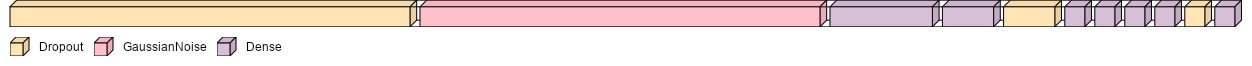

In [46]:
# !pip install visualkeras
import visualkeras

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(10000,),))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(64, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(32, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(8, activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()


visualkeras.layered_view(model, legend=True) # without custom font
from PIL import ImageFont
from collections import defaultdict
from keras import layers
color_map = defaultdict(dict)
color_map[layers.Input]['fill'] = '#FFC0CB'
color_map[layers.GaussianNoise]['fill'] = '#FFC0CB'
color_map[layers.Dense]['fill'] = '#D8BFD8'
color_map[layers.Dropout]['fill'] = '#FFE4B5'
visualkeras.layered_view(model, legend=True, font=font,color_map=color_map) 

# font = ImageFont.truetype("arial.ttf", 12)
# visualkeras.layered_view(model, legend=True, font=font) # selected font

In [61]:
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
import numpy as np
import keras

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    def __data_augmentation(self, img):
        ''' function for apply some data augmentation '''
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.keras.preprocessing.image.random_rotation(img,40)        
        
#         img = tf.keras.preprocessing.image.random_shift(img, 0.2, 0.3)

#         img = tf.keras.preprocessing.image.random_zoom(img,(0.5,0.5))


        return img

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
#         X = np.empty((self.batch_size, *self.dim, self.n_channels))
        X = np.empty((self.batch_size,*self.dim))#3,224,224))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
#             X[i,] =  np.load('./embeddings/vit/'+ str(ID) + '.npy') #np.load('data/' + ID + '.npy')
#             X[i,] =  np.load( (ID))

            img = load_img(img_dir+'/'+ID , target_size=(224, 224))
            img = img_to_array(img,data_format='channels_first')
            img = self.__data_augmentation(img)

            X[i,] = np.expand_dims(img, axis=0)



            # Store class
            y[i] = self.labels[ID]
#         print('X.shape', X.shape)
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

import numpy as np

from keras.models import Sequential
# from my_classes import DataGenerator

# Parameters
params = {'dim': (3,224,224),#(3,224,224),# ( 1, 768),# ( 197, 768), #(32,32,32),
          'batch_size': 32,# 512,# 128,
          'n_classes': 8,#962,
#           'n_channels': 1,
          'shuffle': True}

# Datasets
# partition = # IDs
# labels = # Labels

# j = pd.read_csv('j.csv',index_col=0)[['pid','tagencode']]
# j = j[:]
# j
# partition={'train': list(j['pid'][:int(0.8*len(j))]),
#            'validation': list(j['pid'][int(0.8*len(j)):])}
# labels = (j[['pid','tagencode']].set_index('pid')).to_dict()['tagencode']

j = pd.DataFrame(data={'pid':list(data.filename), 'tagencode':list(data.label_int)})

partition={'train': list(data.path[:int(0.8*len(j))]),
           'validation': list(data.path[int(0.8*len(j)):])}
# j['tagencode'] = labels
labels = (data[['path','cl2']].set_index('path')).to_dict()['cl2']
# labels = (data[['path','label_int']].set_index('path')).to_dict()['label_int']

# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

# history = model.fit(training_generator, validation_data=validation_generator, epochs = 15)#, batch_size = 32)


In [59]:
data

,label_int,filename,path,cl1,cl2
2513,1,SOB_M_DC-14-16188-100-012.png,BreaKHis_v1/histology_slides/breast/malignant/...,M,0
7364,1,SOB_M_LC-14-15570-200-037.png,BreaKHis_v1/histology_slides/breast/malignant/...,M,3
2,0,SOB_B_A-14-22549AB-100-003.png,BreaKHis_v1/histology_slides/breast/benign/SOB...,B,7
3613,1,SOB_M_DC-14-8168-40-003.png,BreaKHis_v1/histology_slides/breast/malignant/...,M,0
2347,1,SOB_M_DC-14-15572-40-022.png,BreaKHis_v1/histology_slides/breast/malignant/...,M,0
...,...,...,...,...,...
1456,0,SOB_B_TA-14-21978AB-40-015.png,BreaKHis_v1/histology_slides/breast/benign/SOB...,B,4
3558,1,SOB_M_DC-14-5695-40-014.png,BreaKHis_v1/histology_slides/breast/malignant/...,M,0
2980,1,SOB_M_DC-14-20629-40-004.png,BreaKHis_v1/histology_slides/breast/malignant/...,M,0
6485,1,SOB_M_DC-14-17915-100-009.png,BreaKHis_v1/histology_slides/breast/malignant/...,M,0


In [69]:
from transformers import ViTFeatureExtractor, ViTModel
import tensorflow as tf
from transformers import TFViTModel

# feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
# model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
base_model.trainable = False
# for layer in base_model.layers[-3:]:
#         if not isinstance(layer, layers.BatchNormalization):
#             layer.trainable = True

pixel_values = tf.keras.layers.Input(shape=(3, 224,224)
                                     , name='pixel_values', dtype='float32')


# vit = base_model(pixel_values)[0]
vit = base_model.vit(pixel_values)[0]
# classifier = tf.keras.layers.Dense(1 , activation='sigmoid', name='outputs')(vit[:, 0, :])
vit = GlobalAveragePooling1D()(vit)
# vit = tf.keras.layers.Dense(128 , activation='relu')(vit)
# classifier = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(vit)
classifier = tf.keras.layers.Dense(8, activation='softmax', name='outputs')(vit)


model = tf.keras.Model(inputs=pixel_values, outputs=classifier)
print(model.summary())



All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pixel_values (InputLayer)   [(None, 3, 224, 224)]     0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPoo  86389248  
                             ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 global_average_pooling1d_6   (None, 768)              0         
 (GlobalAveragePooling1D)                                        
                                                           

In [70]:

# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)


# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.7)
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

# model.compile(
#     optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
# history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 15, batch_size = 32)
# history = model.fit(train, validation_data=valid, validation_data = (x_test, y_test), epochs = 15, batch_size = 32)

opt = SGD(lr=0.01, momentum=0.9)
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# from keras.optimizers import SGD
# opt = SGD(lr=0.01)
# model.compile(loss = "categorical_crossentropy", optimizer = opt)

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=METRICS)#'Adam'

# from sklearn.utils import compute_class_weight
# classWeight = compute_class_weight('balanced',[0,1] , j['tagencode']) 
# classWeight = dict(enumerate(classWeight))
history = model.fit(training_generator, validation_data=validation_generator, epochs = 30)#,class_weight=classWeight)#, batch_size = 32)



Epoch 1/30
197/197 [==============================] - 554s 3s/step - loss: 1.6223 - accuracy: 0.8865 - precision: 0.6221 - recall: 0.2335 - auc: 0.7750 - f1_score: 0.3273 - val_loss: 1.6106 - val_accuracy: 0.8896 - val_precision: 0.6770 - val_recall: 0.2232 - val_auc: 0.7857 - val_f1_score: 0.3306
Epoch 2/30
197/197 [==============================] - 736s 4s/step - loss: 1.5521 - accuracy: 0.8901 - precision: 0.6481 - recall: 0.2644 - auc: 0.8047 - f1_score: 0.3704 - val_loss: 1.5863 - val_accuracy: 0.8886 - val_precision: 0.6151 - val_recall: 0.2915 - val_auc: 0.7985 - val_f1_score: 0.3917
Epoch 3/30
197/197 [==============================] - 1088s 6s/step - loss: 1.5323 - accuracy: 0.8900 - precision: 0.6439 - recall: 0.2682 - auc: 0.8130 - f1_score: 0.3747 - val_loss: 1.5690 - val_accuracy: 0.8898 - val_precision: 0.6500 - val_recall: 0.2570 - val_auc: 0.8021 - val_f1_score: 0.3652
Epoch 4/30
197/197 [==============================] - 351s 2s/step - loss: 1.5214 - accuracy: 0.8904 -


KeyboardInterrupt



In [3]:
### generate ViT vectors after augmentation and normalization
# import tensorflow as tf
# import keras.backend as K
# from sklearn.metrics import classification_report,confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import keras

import numpy as np
import pandas as pd


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


In [3]:
import torch
from torchvision import transforms
import torchstain
import cv2

path = 'BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png'
# path2 = 'BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-4364/100X/SOB_M_DC-14-4364-100-004.png'
target = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
# to_transform = cv2.cvtColor(cv2.imread(path2), cv2.COLOR_BGR2RGB)

T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*255)
])

torch_normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
torch_normalizer.fit(T(target))

# t_to_transform = T(to_transform)
# norm, H, E = torch_normalizer.normalize(I=t_to_transform, stains=True)


C:\Users\mesla\PycharmProjects\breast_cancer_detection\venv\lib\site-packages\torchstain\torch\normalizers\macenko.py:58: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:3041.)
  _, eigvecs = torch.symeig(cov(ODhat.T), eigenvectors=True)
C:\Users\mesla\PycharmProjects\breast_cancer_detection\venv\lib\site-packages\torchstain\torch\normalizers\macenko.py:52: UserWarning: torch.lstsq is deprecated in favor of torc

In [4]:
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result


from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image
import requests

# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
# inputs = feature_extractor(images=image, return_tensors="pt")

# outputs = model(**inputs)
# last_hidden_states = outputs.last_hidden_state
# last_hidden_states.shape

In [27]:
data
i = 0.8
train, test = data[:int(len(data)*i)], data[int(len(data)*i):]
train

,label_int,filename,path,cl1,cl2
2815,1,SOB_M_DC-14-17901-100-008.png,BreaKHis_v1/histology_slides/breast/malignant/...,M,0
5532,0,SOB_B_PT-14-21998AB-100-006.png,BreaKHis_v1/histology_slides/breast/benign/SOB...,B,6
4553,1,SOB_M_MC-14-19979-100-018.png,BreaKHis_v1/histology_slides/breast/malignant/...,M,2
3438,1,SOB_M_DC-14-5694-200-006.png,BreaKHis_v1/histology_slides/breast/malignant/...,M,0
3023,1,SOB_M_DC-14-20629-400-011.png,BreaKHis_v1/histology_slides/breast/malignant/...,M,0
...,...,...,...,...,...
4688,1,SOB_M_PC-14-12465-40-015.png,BreaKHis_v1/histology_slides/breast/malignant/...,M,5
5399,0,SOB_B_F-14-23222AB-400-017.png,BreaKHis_v1/histology_slides/breast/benign/SOB...,B,1
1387,0,SOB_B_TA-14-19854C-40-013.png,BreaKHis_v1/histology_slides/breast/benign/SOB...,B,4
7419,1,SOB_M_LC-14-15570-40-037.png,BreaKHis_v1/histology_slides/breast/malignant/...,M,3


In [29]:
# vecs = []
# labels = []
# from tqdm import tqdm

# for ind,row in tqdm(train.iterrows(), total=train.shape[0]):
    
#     img = cv2.imread('BreaKHis_v1/'+row['path'])
#     to_transform = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     T = transforms.Compose([transforms.ToTensor(),    transforms.Lambda(lambda x: x*255)])
#     torch_normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
#     torch_normalizer.fit(T(target))
#     t_to_transform = T(to_transform)
#     norm, H, E = torch_normalizer.normalize(I=t_to_transform, stains=True)

#     img = np.array(norm).astype(np.uint8)
# #     img2 = rotate_image(img,np.random.randint(10,40))
#     img3 = cv2.flip(img,1)
#     img4 = cv2.flip(img,0)

# #     plt.imshow(img)
# #     plt.show()
# #     plt.imshow(img2)
# #     plt.show()
# #     plt.imshow(img3)
# #     plt.show()
# #     plt.imshow(img4)
# #     plt.show()

    
# #     for i in [img, img2, img3, img4]:
#     for i in [img, img4]:
#         inputs = feature_extractor(images=i, return_tensors="pt")
#         outputs = model(**inputs)
#         last_hidden_states = (outputs.last_hidden_state).detach().numpy()

#         vecs.append((last_hidden_states.reshape(-1)))
#         labels.append(row['cl2'])




In [53]:
# #october
# vecs = []
pathes = []
labels = []
from tqdm import tqdm

for ind,row in tqdm(train.iterrows(), total=train.shape[0]):
    
    img = cv2.imread('BreaKHis_v1/'+row['path'])
    pid = row['path'].split('/')[-1].split('.')[0]
    
    to_transform = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    T = transforms.Compose([transforms.ToTensor(),    transforms.Lambda(lambda x: x*255)])
    torch_normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
    torch_normalizer.fit(T(target))
    t_to_transform = T(to_transform)
    norm, H, E = torch_normalizer.normalize(I=t_to_transform, stains=True)

    img = np.array(norm).astype(np.uint8)
#     img2 = rotate_image(img,np.random.randint(10,40))
    img3 = cv2.flip(img,1)
    img4 = cv2.flip(img,0)
    img5 = cv2.flip(img3,0)

#     plt.imshow(img)
#     plt.show()
#     plt.imshow(img2)
#     plt.show()
#     plt.imshow(img3)
#     plt.show()
#     plt.imshow(img4)
#     plt.show()
#     plt.imshow(img5)
#     plt.show()

    
#     for i in [img, img2, img3, img4]:
    for ind,i in enumerate([img, img3, img4, img5]):
        path = ('breakhis_vecs/train/'+pid+'-'+str(ind)+'.npy')
        inputs = feature_extractor(images=i, return_tensors="pt")
        outputs = model(**inputs)
        last_hidden_states = (outputs.last_hidden_state).detach().numpy().reshape(-1)
#         print(last_hidden_states.shape, row['cl2'])

#         vecs.append((last_hidden_states.reshape(-1)))
        np.save(path, last_hidden_states)
        pathes.append(path)
        labels.append(row['cl2'])




# pathes, labels

100%|██████████| 6327/6327 [4:01:29<00:00,  2.29s/it]  


In [54]:
df_train = pd.DataFrame(data={'pathes':pathes, 'labels':labels})
df_train

,pathes,labels
0,breakhis_vecs/train/SOB_M_DC-14-17901-100-008-...,0
1,breakhis_vecs/train/SOB_M_DC-14-17901-100-008-...,0
2,breakhis_vecs/train/SOB_M_DC-14-17901-100-008-...,0
3,breakhis_vecs/train/SOB_M_DC-14-17901-100-008-...,0
4,breakhis_vecs/train/SOB_B_PT-14-21998AB-100-00...,6
...,...,...
25303,breakhis_vecs/train/SOB_M_LC-14-15570-40-037-3...,3
25304,breakhis_vecs/train/SOB_M_LC-14-13412-100-005-...,3
25305,breakhis_vecs/train/SOB_M_LC-14-13412-100-005-...,3
25306,breakhis_vecs/train/SOB_M_LC-14-13412-100-005-...,3


In [64]:
len(train)*4


25308

In [57]:
# #october
# vecs = []
pathes = []
labels = []
from tqdm import tqdm

for ind,row in tqdm(test.iterrows(), total=test.shape[0]):
    
    img = cv2.imread('BreaKHis_v1/'+row['path'])
    pid = row['path'].split('/')[-1].split('.')[0]
    
    to_transform = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    T = transforms.Compose([transforms.ToTensor(),    transforms.Lambda(lambda x: x*255)])
    torch_normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
    torch_normalizer.fit(T(target))
    t_to_transform = T(to_transform)
    norm, H, E = torch_normalizer.normalize(I=t_to_transform, stains=True)

    img = np.array(norm).astype(np.uint8)
#     img2 = rotate_image(img,np.random.randint(10,40))
#     img3 = cv2.flip(img,1)
#     img4 = cv2.flip(img,0)
#     img5 = cv2.flip(img3,0)

#     plt.imshow(img)
#     plt.show()
#     plt.imshow(img2)
#     plt.show()
#     plt.imshow(img3)
#     plt.show()
#     plt.imshow(img4)
#     plt.show()
#     plt.imshow(img5)
#     plt.show()

    
#     for i in [img, img2, img3, img4]:
    for ind,i in enumerate([img]):
        path = ('breakhis_vecs/test/'+pid+'-'+str(ind)+'.npy')
        inputs = feature_extractor(images=i, return_tensors="pt")
        outputs = model(**inputs)
        last_hidden_states = (outputs.last_hidden_state).detach().numpy().reshape(-1)
#         print(last_hidden_states.shape, row['cl2'])

#         vecs.append((last_hidden_states.reshape(-1)))
        np.save(path, last_hidden_states)
        pathes.append(path)
        labels.append(row['cl2'])




# pathes, labels

100%|██████████| 1582/1582 [17:21<00:00,  1.52it/s]


In [58]:
df_test = pd.DataFrame(data={'pathes':pathes, 'labels':labels})
df_test

,pathes,labels
0,breakhis_vecs/test/SOB_M_DC-14-17614-100-017-0...,0
1,breakhis_vecs/test/SOB_M_DC-14-2523-200-030-0.npy,0
2,breakhis_vecs/test/SOB_M_MC-14-18842D-200-013-...,2
3,breakhis_vecs/test/SOB_M_PC-15-190EF-400-011-0...,5
4,breakhis_vecs/test/SOB_B_TA-14-16184-200-005-0...,4
...,...,...
1577,breakhis_vecs/test/SOB_B_F-14-21998CD-100-031-...,1
1578,breakhis_vecs/test/SOB_B_F-14-23222AB-400-008-...,1
1579,breakhis_vecs/test/SOB_B_F-14-25197-400-058-0.npy,1
1580,breakhis_vecs/test/SOB_M_MC-14-18842D-100-010-...,2


In [60]:
df = pd.concat([df_train,df_test])
df

,pathes,labels
0,breakhis_vecs/train/SOB_M_DC-14-17901-100-008-...,0
1,breakhis_vecs/train/SOB_M_DC-14-17901-100-008-...,0
2,breakhis_vecs/train/SOB_M_DC-14-17901-100-008-...,0
3,breakhis_vecs/train/SOB_M_DC-14-17901-100-008-...,0
4,breakhis_vecs/train/SOB_B_PT-14-21998AB-100-00...,6
...,...,...
1577,breakhis_vecs/test/SOB_B_F-14-21998CD-100-031-...,1
1578,breakhis_vecs/test/SOB_B_F-14-23222AB-400-008-...,1
1579,breakhis_vecs/test/SOB_B_F-14-25197-400-058-0.npy,1
1580,breakhis_vecs/test/SOB_M_MC-14-18842D-100-010-...,2


In [16]:
df.to_csv('partition.csv')

In [2]:
import pandas as pd
df = pd.read_csv('partition.csv',index_col=0)
df

,pathes,labels,path10k
0,breakhis_vecs/train/SOB_M_DC-14-17901-100-008-...,0,breakhis_vecs_10k/train/0.npy
1,breakhis_vecs/train/SOB_M_DC-14-17901-100-008-...,0,breakhis_vecs_10k/train/1.npy
2,breakhis_vecs/train/SOB_M_DC-14-17901-100-008-...,0,breakhis_vecs_10k/train/2.npy
3,breakhis_vecs/train/SOB_M_DC-14-17901-100-008-...,0,breakhis_vecs_10k/train/3.npy
4,breakhis_vecs/train/SOB_B_PT-14-21998AB-100-00...,6,breakhis_vecs_10k/train/4.npy
...,...,...,...
1577,breakhis_vecs/test/SOB_B_F-14-21998CD-100-031-...,1,breakhis_vecs_10k/test/1577.npy
1578,breakhis_vecs/test/SOB_B_F-14-23222AB-400-008-...,1,breakhis_vecs_10k/test/1578.npy
1579,breakhis_vecs/test/SOB_B_F-14-25197-400-058-0.npy,1,breakhis_vecs_10k/test/1579.npy
1580,breakhis_vecs/test/SOB_M_MC-14-18842D-100-010-...,2,breakhis_vecs_10k/test/1580.npy


In [4]:
import numpy as np
import keras

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=16, dim=(151296,), n_classes=8, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
#         X = np.empty((self.batch_size, *self.dim, self.n_channels))
        X = np.empty((self.batch_size,*self.dim))#3,224,224))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            X[i,] =  np.load( (ID))
            y[i] = self.labels[ID]
        return X,tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

import numpy as np

from keras.models import Sequential

n_classes =8
params = {'dim': (10000,),#(3,224,224),# ( 1, 768),# ( 197, 768), #(32,32,32),
          'batch_size': 16,# 512,# 128,
          'n_classes': 8,#962,
          'shuffle': True}


# partition={'train': list(df.pathes[:25308]), 'validation': list(df.pathes[25308:])}
# labels = dict(zip(list(df.pathes), list(df.labels)))

partition={'train': list(df.path10k[:25308]), 'validation': list(df.path10k[25308:])}
labels = dict(zip(list(df.path10k), list(df.labels)))

# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)
for x,y in training_generator:
    print(x.shape, y.shape)
    break


(16, 10000) (16, 8)


In [13]:
df

,pathes,labels
0,breakhis_vecs/train/SOB_M_DC-14-17901-100-008-...,0
1,breakhis_vecs/train/SOB_M_DC-14-17901-100-008-...,0
2,breakhis_vecs/train/SOB_M_DC-14-17901-100-008-...,0
3,breakhis_vecs/train/SOB_M_DC-14-17901-100-008-...,0
4,breakhis_vecs/train/SOB_B_PT-14-21998AB-100-00...,6
...,...,...
1577,breakhis_vecs/test/SOB_B_F-14-21998CD-100-031-...,1
1578,breakhis_vecs/test/SOB_B_F-14-23222AB-400-008-...,1
1579,breakhis_vecs/test/SOB_B_F-14-25197-400-058-0.npy,1
1580,breakhis_vecs/test/SOB_M_MC-14-18842D-100-010-...,2


In [1]:
import glob
import numpy as np


train_vecs = []
for p in (glob.glob("breakhis_vecs/train/*.npy")):
    vec = np.load(p)
    train_vecs.append(vec)

test_vecs = []
for p in (glob.glob("breakhis_vecs/test/*.npy")):
    vec = np.load(p)
    test_vecs.append(vec)

print(len(train_vecs), len(test_vecs))

25308 1582


In [14]:
path10k = []
for ind, vec in enumerate(X_train_kbest):
    path = ('breakhis_vecs_10k/train/'+str(ind)+'.npy')
    path10k.append(path)

for ind, vec in enumerate(X_test_kbest):
    path = ('breakhis_vecs_10k/test/'+str(ind)+'.npy')
    path10k.append(path)

print('done :)')

done :)


In [15]:
df['path10k'] = path10k
df

,pathes,labels,path10k
0,breakhis_vecs/train/SOB_M_DC-14-17901-100-008-...,0,breakhis_vecs_10k/train/0.npy
1,breakhis_vecs/train/SOB_M_DC-14-17901-100-008-...,0,breakhis_vecs_10k/train/1.npy
2,breakhis_vecs/train/SOB_M_DC-14-17901-100-008-...,0,breakhis_vecs_10k/train/2.npy
3,breakhis_vecs/train/SOB_M_DC-14-17901-100-008-...,0,breakhis_vecs_10k/train/3.npy
4,breakhis_vecs/train/SOB_B_PT-14-21998AB-100-00...,6,breakhis_vecs_10k/train/4.npy
...,...,...,...
1577,breakhis_vecs/test/SOB_B_F-14-21998CD-100-031-...,1,breakhis_vecs_10k/test/1577.npy
1578,breakhis_vecs/test/SOB_B_F-14-23222AB-400-008-...,1,breakhis_vecs_10k/test/1578.npy
1579,breakhis_vecs/test/SOB_B_F-14-25197-400-058-0.npy,1,breakhis_vecs_10k/test/1579.npy
1580,breakhis_vecs/test/SOB_M_MC-14-18842D-100-010-...,2,breakhis_vecs_10k/test/1580.npy


In [22]:
# train_vecs

a = list(range(50))
a[::4]


[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48]

In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2,mutual_info_regression


fvalue_Best = SelectKBest(f_classif, k=10000)
X_train_kbest = fvalue_Best.fit_transform(train_vecs[::4], df.labels[:25308:4])
X_test_kbest = fvalue_Best.transform(test_vecs)
print(X_train_kbest.shape, X_test_kbest.shape)



(6327, 10000) (1582, 10000)


In [7]:
X_train_kbest = fvalue_Best.transform(train_vecs)


In [8]:
print(X_train_kbest.shape, X_test_kbest.shape)


(25308, 10000) (1582, 10000)


In [11]:
for ind, vec in enumerate(X_train_kbest):
    path = ('breakhis_vecs_10k/train/'+str(ind)+'.npy')
    np.save(path, vec)

for ind, vec in enumerate(X_test_kbest):
    path = ('breakhis_vecs_10k/test/'+str(ind)+'.npy')
    np.save(path, vec)
print('done :)')

done :)


In [9]:

# fvalue_Best = SelectKBest(f_classif, k=10000)
# X_kbest = fvalue_Best.fit_transform(list(df.vecs), list(df.labels))
# print(X_kbest.shape)

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(10000,),))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(64, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(32, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()


opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)#'Adam'

history = model.fit(training_generator, validation_data=(validation_generator), epochs = 500,batch_size=128, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_7 (Dropout)         (None, 10000)             0         
                                                                 
 gaussian_noise_3 (GaussianN  (None, 10000)            0         
 oise)                                                           
                                                                 
 dense_16 (Dense)            (None, 1024)              10241024  
                                                                 
 dense_17 (Dense)            (None, 512)               524800    
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               65664     
                                                      

Epoch 20/500
1581/1581 [==============================] - 29s 18ms/step - loss: 1.5573 - accuracy: 0.8983 - precision: 0.7720 - recall: 0.2640 - auc: 0.7987 - f1_score: 0.3844 - val_loss: 2.1738 - val_accuracy: 0.8721 - val_precision: 0.4646 - val_recall: 0.1550 - val_auc: 0.6793 - val_f1_score: 0.2286
Epoch 21/500
1581/1581 [==============================] - 29s 18ms/step - loss: 1.5470 - accuracy: 0.8994 - precision: 0.7844 - recall: 0.2689 - auc: 0.8018 - f1_score: 0.3897 - val_loss: 2.0833 - val_accuracy: 0.8726 - val_precision: 0.4534 - val_recall: 0.0931 - val_auc: 0.6679 - val_f1_score: 0.1507
Epoch 22/500
1581/1581 [==============================] - 29s 19ms/step - loss: 1.5340 - accuracy: 0.9006 - precision: 0.7872 - recall: 0.2806 - auc: 0.8059 - f1_score: 0.4039 - val_loss: 2.1436 - val_accuracy: 0.8720 - val_precision: 0.4484 - val_recall: 0.1052 - val_auc: 0.6725 - val_f1_score: 0.1656
Epoch 23/500
1581/1581 [==============================] - 29s 18ms/step - loss: 1.5284 -

Epoch 47/500
1581/1581 [==============================] - 29s 19ms/step - loss: 1.2336 - accuracy: 0.9171 - precision: 0.8403 - recall: 0.4162 - auc: 0.8861 - f1_score: 0.5482 - val_loss: 2.4611 - val_accuracy: 0.8685 - val_precision: 0.4307 - val_recall: 0.1626 - val_auc: 0.6356 - val_f1_score: 0.2323
Epoch 48/500
1581/1581 [==============================] - 30s 19ms/step - loss: 1.2243 - accuracy: 0.9178 - precision: 0.8407 - recall: 0.4226 - auc: 0.8878 - f1_score: 0.5543 - val_loss: 2.6139 - val_accuracy: 0.8662 - val_precision: 0.4101 - val_recall: 0.1601 - val_auc: 0.6297 - val_f1_score: 0.2249
Epoch 49/500
1581/1581 [==============================] - 30s 19ms/step - loss: 1.2052 - accuracy: 0.9188 - precision: 0.8449 - recall: 0.4291 - auc: 0.8915 - f1_score: 0.5610 - val_loss: 2.5768 - val_accuracy: 0.8667 - val_precision: 0.4033 - val_recall: 0.1384 - val_auc: 0.6239 - val_f1_score: 0.2016
Epoch 50/500
1581/1581 [==============================] - 30s 19ms/step - loss: 1.2017 -

Epoch 74/500
1581/1581 [==============================] - 30s 19ms/step - loss: 0.9497 - accuracy: 0.9374 - precision: 0.8730 - recall: 0.5838 - auc: 0.9344 - f1_score: 0.6946 - val_loss: 2.9759 - val_accuracy: 0.8578 - val_precision: 0.3590 - val_recall: 0.1754 - val_auc: 0.6362 - val_f1_score: 0.2312
Epoch 75/500
1581/1581 [==============================] - 30s 19ms/step - loss: 0.9416 - accuracy: 0.9379 - precision: 0.8776 - recall: 0.5844 - auc: 0.9358 - f1_score: 0.6959 - val_loss: 3.2489 - val_accuracy: 0.8599 - val_precision: 0.3810 - val_recall: 0.1939 - val_auc: 0.6468 - val_f1_score: 0.2521
Epoch 76/500
1581/1581 [==============================] - 30s 19ms/step - loss: 0.9288 - accuracy: 0.9390 - precision: 0.8796 - recall: 0.5932 - auc: 0.9381 - f1_score: 0.7036 - val_loss: 3.1968 - val_accuracy: 0.8570 - val_precision: 0.3562 - val_recall: 0.1786 - val_auc: 0.6252 - val_f1_score: 0.2346
Epoch 77/500
1581/1581 [==============================] - 30s 19ms/step - loss: 0.9312 -


KeyboardInterrupt



In [6]:
del model

In [ ]:
vecs = []
labels = []
from tqdm import tqdm

for ind,row in tqdm(test.iterrows(), total=test.shape[0]):
    
    img = cv2.imread('BreaKHis_v1/'+row['path'])
    to_transform = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    T = transforms.Compose([transforms.ToTensor(),    transforms.Lambda(lambda x: x*255)])
    torch_normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
    torch_normalizer.fit(T(target))
    t_to_transform = T(to_transform)
    norm, H, E = torch_normalizer.normalize(I=t_to_transform, stains=True)

    img = np.array(norm).astype(np.uint8)
    
    inputs = feature_extractor(images=img, return_tensors="pt")
    outputs = model(**inputs)
    last_hidden_states = (outputs.last_hidden_state).detach().numpy()

    vecs.append((last_hidden_states.reshape(-1)))
    labels.append(row['cl2'])


df_test = pd.DataFrame(data={'vecs':vecs, 'labels':labels})
# df_test.to_parquet('vec_parquet_aug_norm_test.gzip')
df_test

 51%|█████     | 806/1582 [10:49<10:36,  1.22it/s]

In [275]:
df = pd.DataFrame(data={'vecs':vecs, 'labels':labels})
df

,vecs,labels
0,"[-0.2288592, -0.07357915, -0.2962783, -0.36338...",6
1,"[-0.0819048, -0.008585747, -0.36059004, -0.300...",6
2,"[-0.23424837, -0.08643839, -0.32671082, -0.400...",6
3,"[-0.1899551, -0.060493376, -0.35343722, -0.432...",6
4,"[-0.16406535, -0.0888235, -0.35369882, -0.3153...",7
...,...,...
25303,"[-0.16808009, -0.13741858, -0.20960805, -0.210...",4
25304,"[-0.27421764, -0.09455232, -0.42730093, -0.210...",0
25305,"[-0.22254464, 0.18311857, -0.5127546, -0.40853...",0
25306,"[-0.27870256, -0.08751729, -0.41644824, -0.207...",0


In [12]:
df = pd.DataFrame(data={'vecs':vecs, 'labels':labels})
df

,vecs,labels
0,"[-0.16904321, -0.11835502, -0.5152824, -0.3332...",0
1,"[-0.21044497, -0.05118373, -0.39494804, -0.300...",0
2,"[-0.17666067, 0.027672116, -0.062421244, -0.00...",3
3,"[-0.18658692, -0.09863134, -0.22182481, -0.143...",3
4,"[-0.27658507, 0.04118702, -0.27649438, -0.0777...",0
...,...,...
12649,"[-0.3892829, -0.056356642, -0.38343433, -0.279...",1
12650,"[-0.31793946, -0.14458238, -0.007798697, 0.062...",2
12651,"[-0.23258366, -0.31485406, 0.041473817, 0.0979...",2
12652,"[-0.11971708, -0.111991525, -0.19883332, -0.19...",1


In [280]:
# df[:4000].to_parquet('vec_parquet_aug_norm.gzip')
# df[4000:8000].to_parquet('vec_parquet_aug_norm2.gzip')
# df[8000:12000].to_parquet('vec_parquet_aug_norm3.gzip')
# df[12000:16000].to_parquet('vec_parquet_aug_norm4.gzip')
# df[16000:20000].to_parquet('vec_parquet_aug_norm5.gzip')
# df[20000:].to_parquet('vec_parquet_aug_norm6.gzip')


In [2]:

# df = pd.read_parquet('vec_parquet_aug_norm.gzip')    
# df = pd.read_parquet('vec_parquet_aug_norm2.gzip')    
# df = pd.read_parquet('vec_parquet_aug_norm3.gzip')    
# df = pd.read_parquet('vec_parquet_aug_norm4.gzip')    
# df = pd.read_parquet('vec_parquet_aug_norm5.gzip')    
df = pd.read_parquet('vec_parquet_aug_norm6.gzip') 
# 


# df2 = pd.concat([df5,df6])


# # d1 = [i+1 for i in range(0,25308,4)]
# d2 = [i+2 for i in range(0,8000,4)]
# d3 = [i+2 for i in range(0,6000,4)]

# # df = df.drop(df.index[d1])
# df2 = df2.drop(df2.index[d2])
# df2 = df2.drop(df2.index[d3])

df

,vecs,labels
20000,"[-0.077861875, -0.27255997, -0.31940845, -0.10...",1
20001,"[-0.07942125, -0.12794639, -0.36949947, -0.225...",1
20002,"[-0.060571212, -0.26923496, -0.3113737, -0.124...",1
20003,"[-0.09405956, -0.27110422, -0.3885518, -0.2187...",1
20004,"[-0.20814872, -0.17453013, -0.45716318, -0.070...",6
...,...,...
25303,"[-0.16808009, -0.13741858, -0.20960805, -0.210...",4
25304,"[-0.27421764, -0.09455232, -0.42730093, -0.210...",0
25305,"[-0.22254464, 0.18311857, -0.5127546, -0.40853...",0
25306,"[-0.27870256, -0.08751729, -0.41644824, -0.207...",0


In [3]:

d1 = [i+1 for i in range(20000,25307,4)]
d2 = [i+2 for i in range(20000,25307,4)]
d3 = [i+3 for i in range(20000,25307,4)]

df = df.drop(d1)
df = df.drop(d2)
df = df.drop(d3)


df

,vecs,labels
20000,"[-0.077861875, -0.27255997, -0.31940845, -0.10...",1
20004,"[-0.20814872, -0.17453013, -0.45716318, -0.070...",6
20008,"[-0.3149512, -0.14521363, -0.18967694, -0.1425...",0
20012,"[-0.17119393, -0.15638047, -0.35053918, -0.413...",0
20016,"[-0.2812857, -0.097590476, -0.39258853, -0.286...",1
...,...,...
25288,"[-0.2918048, -0.16874348, -0.56654286, -0.4233...",0
25292,"[-0.27690238, -0.094004706, -0.32291475, -0.12...",0
25296,"[-0.34661007, -0.08171624, -0.41487908, -0.387...",0
25300,"[-0.22747307, -0.21127875, -0.25836962, -0.210...",4


In [5]:
# c = df
c = pd.concat([c, df])
# c.to_parquet('temp.gzip')
c

,vecs,labels
0,"[-0.2288592, -0.07357915, -0.2962783, -0.36338...",6
4,"[-0.16406535, -0.0888235, -0.35369882, -0.3153...",7
8,"[-0.22533788, -0.015310157, -0.20464444, -0.18...",1
12,"[-0.39582568, -0.04760656, -0.40585926, -0.250...",5
16,"[-0.15462503, -0.0034615733, -0.31843302, -0.0...",0
...,...,...
25288,"[-0.2918048, -0.16874348, -0.56654286, -0.4233...",0
25292,"[-0.27690238, -0.094004706, -0.32291475, -0.12...",0
25296,"[-0.34661007, -0.08171624, -0.41487908, -0.387...",0
25300,"[-0.22747307, -0.21127875, -0.25836962, -0.210...",4


In [44]:
c.index/4
# c = c[~c.index.duplicated(keep='first')]
c

,vecs,labels
0,"[-0.2288592, -0.07357915, -0.2962783, -0.36338...",6
4,"[-0.16406535, -0.0888235, -0.35369882, -0.3153...",7
8,"[-0.22533788, -0.015310157, -0.20464444, -0.18...",1
12,"[-0.39582568, -0.04760656, -0.40585926, -0.250...",5
16,"[-0.15462503, -0.0034615733, -0.31843302, -0.0...",0
...,...,...
19980,"[-0.22972403, -0.13859552, -0.31666347, -0.204...",0
19984,"[-0.17793539, -0.020396948, -0.40328473, -0.21...",0
19988,"[-0.21154875, -0.084616035, -0.3312215, -0.207...",6
19992,"[-0.37236124, -0.1783342, -0.2904821, -0.30224...",0


In [6]:
c.to_parquet('temp.gzip')
# df2.to_parquet('temp2.gzip')

# c = pd.read_parquet('temp.gzip')
# # df = pd.concat([df,df2])
c

,vecs,labels
0,"[-0.2288592, -0.07357915, -0.2962783, -0.36338...",6
4,"[-0.16406535, -0.0888235, -0.35369882, -0.3153...",7
8,"[-0.22533788, -0.015310157, -0.20464444, -0.18...",1
12,"[-0.39582568, -0.04760656, -0.40585926, -0.250...",5
16,"[-0.15462503, -0.0034615733, -0.31843302, -0.0...",0
...,...,...
25288,"[-0.2918048, -0.16874348, -0.56654286, -0.4233...",0
25292,"[-0.27690238, -0.094004706, -0.32291475, -0.12...",0
25296,"[-0.34661007, -0.08171624, -0.41487908, -0.387...",0
25300,"[-0.22747307, -0.21127875, -0.25836962, -0.210...",4


In [10]:
c = pd.read_parquet('temp.gzip')
c

,vecs,labels
0,"[-0.2288592, -0.07357915, -0.2962783, -0.36338...",6
4,"[-0.16406535, -0.0888235, -0.35369882, -0.3153...",7
8,"[-0.22533788, -0.015310157, -0.20464444, -0.18...",1
12,"[-0.39582568, -0.04760656, -0.40585926, -0.250...",5
16,"[-0.15462503, -0.0034615733, -0.31843302, -0.0...",0
...,...,...
25288,"[-0.2918048, -0.16874348, -0.56654286, -0.4233...",0
25292,"[-0.27690238, -0.094004706, -0.32291475, -0.12...",0
25296,"[-0.34661007, -0.08171624, -0.41487908, -0.387...",0
25300,"[-0.22747307, -0.21127875, -0.25836962, -0.210...",4


In [15]:
int(7909*0.8)*2

12654

In [14]:
c2 = pd.read_parquet('10k_2aug_norm.gzip')
c2

,vecs,labels
0,"[-0.28977516, 0.15062663, 0.078366384, -0.0491...",0
1,"[-0.18938121, 0.1439855, 0.060851704, -0.01307...",0
2,"[-0.16156681, 0.18008389, -0.060026716, -0.129...",3
3,"[-0.18179937, 0.17078193, -0.103581905, -0.078...",3
4,"[-0.07676768, 0.3148747, 0.07720131, -0.083837...",0
...,...,...
12649,"[-0.18966086, 0.31694928, 0.07666491, -0.10504...",1
12650,"[-0.19973245, 0.34686914, -0.031443793, -0.103...",2
12651,"[-0.25322562, 0.34421962, 0.01623007, -0.04454...",2
12652,"[-0.18997549, 0.26073763, 0.016868971, -0.0742...",1


In [2]:

# df[:4000].to_parquet('temp_2aug1.gzip')
# df[4000:8000].to_parquet('temp_2aug2.gzip')
# df[8000:].to_parquet('temp_2aug3.gzip')

import pandas as pd
df = pd.read_parquet('temp_2aug1.gzip')    
df2 = pd.read_parquet('temp_2aug2.gzip')    
df3 = pd.read_parquet('temp_2aug3.gzip')    

df = pd.concat([df,df2,df3])

df

,vecs,labels
0,"[-0.16904321, -0.11835502, -0.5152824, -0.3332...",0
1,"[-0.21044497, -0.05118373, -0.39494804, -0.300...",0
2,"[-0.17666067, 0.027672116, -0.062421244, -0.00...",3
3,"[-0.18658692, -0.09863134, -0.22182481, -0.143...",3
4,"[-0.27658507, 0.04118702, -0.27649438, -0.0777...",0
...,...,...
12649,"[-0.3892829, -0.056356642, -0.38343433, -0.279...",1
12650,"[-0.31793946, -0.14458238, -0.007798697, 0.062...",2
12651,"[-0.23258366, -0.31485406, 0.041473817, 0.0979...",2
12652,"[-0.11971708, -0.111991525, -0.19883332, -0.19...",1


In [6]:
# del df, df2, df3
del train, data

In [4]:

fvalue_Best = SelectKBest(f_classif, k=10000)
X_train_kbest = fvalue_Best.fit_transform(list(df.vecs), list(df.labels))
# X_test_kbest = fvalue_Best.transform(list(test.vecs))
print(X_train_kbest.shape)#, X_test_kbest.shape)

(12654, 10000)


In [5]:
df_new = pd.DataFrame(data={'vecs':list(X_train_kbest), 'labels':df.labels})
df_new.to_parquet('10k_2aug_norm.gzip')
# df_test.to_parquet('10k_2aug_norm_test.gzip')


In [ ]:
X_test_kbest = fvalue_Best.transform(list(test.vecs))
print(X_train_kbest.shape, X_test_kbest.shape)
df_test.to_parquet('10k_2aug_norm_test.gzip')


In [ ]:

# fvalue_Best = SelectKBest(f_classif, k=10000)
# X_train_kbest = fvalue_Best.fit_transform(list(df.vecs), list(df.labels))
X_test_kbest = fvalue_Best.transform(list(df_test.vecs))
print(X_train_kbest.shape, X_test_kbest.shape)

In [7]:

# fvalue_Best = SelectKBest(f_classif, k=10000)
# X_train_kbest = fvalue_Best.fit_transform(list(df.vecs), list(df.labels))
# # X_test_kbest = fvalue_Best.transform(list(test.vecs))
# print(X_train_kbest.shape)#, X_test_kbest.shape)

df_lite = pd.read_parquet('temp.gzip')
fvalue_Best = SelectKBest(f_classif, k=10000)
X_train_kbest = fvalue_Best.fit_transform(list(df_lite.vecs), list(df_lite.labels))
# X_test_kbest = fvalue_Best.transform(list(test.vecs))
print(X_train_kbest.shape)#, X_test_kbest.shape)



(6327, 10000)


In [37]:

# df = pd.read_parquet('vec_parquet_aug_norm.gzip')    
# df = pd.read_parquet('vec_parquet_aug_norm2.gzip')    
# df = pd.read_parquet('vec_parquet_aug_norm3.gzip')    
# df = pd.read_parquet('vec_parquet_aug_norm4.gzip')    
# df = pd.read_parquet('vec_parquet_aug_norm5.gzip')    
# df = pd.read_parquet('vec_parquet_aug_norm6.gzip') 
df = pd.read_parquet('vec_parquet_aug_norm_test.gzip') 

# 

t = fvalue_Best.transform(list(df.vecs))
print(t.shape)

# import numpy as np
# X_train_kbest = np.concatenate((X_train_kbest, t),axis=0)
# X_train_kbest.shape

(1582, 10000)


In [40]:
# test = pd.DataFrame(data={'vecs':(list(t)), 'labels':list(df.labels)})
test.to_parquet('10K_aug_norm_test.gzip')

test

,vecs,labels
0,"[-0.18801017, 0.2969741, 0.059298884, -0.20119...",1
1,"[-0.15364683, 0.13280554, 0.034373317, -0.1762...",5
2,"[-0.20043203, 0.0826799, 0.037129775, -0.44800...",2
3,"[-0.096549086, 0.18571217, 0.1540381, -0.07917...",0
4,"[-0.180401, 0.23846745, 0.20303507, -0.0804228...",7
...,...,...
1577,"[-0.10768193, 0.26426342, -0.06629478, -0.0925...",4
1578,"[-0.27241138, 0.3094237, 0.17590897, -0.022927...",0
1579,"[-0.20567246, 0.41228503, 0.029791337, -0.0747...",6
1580,"[-0.268352, 0.3136338, 0.25267595, 0.022974245...",1


In [35]:
train = pd.DataFrame(data={'vecs':(list(X_train_kbest)), 'labels':labels})
train

,vecs,labels
0,"[0.052626595, 0.2840108, 0.17614494, -0.163736...",6
1,"[-0.18003215, 0.14435238, -0.027957395, 0.1733...",6
2,"[0.02589576, 0.2923499, 0.16783297, -0.0856062...",6
3,"[0.015406106, 0.28112933, 0.22436275, -0.10562...",6
4,"[-0.092503116, 0.19909495, 0.085333854, -0.111...",7
...,...,...
25303,"[-0.26250073, 0.40447304, -0.13814619, -0.2026...",4
25304,"[-0.25866324, 0.3661068, 0.13899586, 0.0140513...",0
25305,"[-0.33732855, 0.39962506, 0.08536565, 0.033367...",0
25306,"[-0.263534, 0.36838093, 0.1443792, 0.000530782...",0


In [303]:
# d1 = [i+1 for i in range(0,25308,4)]
# d2 = [i+2 for i in range(0,25308,4)]
# d3 = [i+3 for i in range(0,25308,4)]

# # df_lite = df.drop(df.index[d1])
# # df_lite = df_lite.drop(df.index[d2])
# # df_lite = df_lite.drop(df.index[d3])

# df_lite

In [36]:
# df_lite.to_parquet('vec_parquet_aug_norm2_lite.gzip')
# train.to_parquet('10K_aug_norm.gzip')


In [44]:

y_train = tf.keras.utils.to_categorical(np.array(train.labels).reshape(-1,1), num_classes=len(set(train.labels)))
y_test = tf.keras.utils.to_categorical(np.array(test.labels).reshape(-1,1), num_classes=len(set(test.labels)))
y_train.shape,y_test.shape
# y_train, y_test = onehot[:int(len(train)*i)], onehot[int(len(train)*i):]
# y_train.shape, y_test.shape

((25308, 8), (1582, 8))

In [ ]:
tf.keras.backend.clear_session()


In [92]:



model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(10000,),))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
# model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(64, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(32, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(len(set(df.labels)), activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()


opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)#'Adam'

history = model.fit(np.array([list(v) for v in train.vecs]), np.array(y_train),
                    validation_data=(np.array([list(v) for v in test.vecs]), np.array(y_test)), epochs = 50,batch_size=4, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)

y_pred = model.predict(np.array([list(v) for v in test.vecs]))
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

cr = classification_report(y_test, y_pred, target_names=['DC','F','C','LC','TA','PC','PT','A'])
print(cr)
     
cm = confusion_matrix(y_test, y_pred)
print(cm)
cm = pd.DataFrame(cm)
cm.index=(['DC','F','C','LC','TA','PC','PT','A'])
cm.columns=(['DC','F','C','LC','TA','PC','PT','A'])

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, cmap='Blues')


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_12 (Dropout)        (None, 10000)             0         
                                                                 
 gaussian_noise_4 (GaussianN  (None, 10000)            0         
 oise)                                                           
                                                                 
 dense_27 (Dense)            (None, 1024)              10241024  
                                                                 
 dense_28 (Dense)            (None, 512)               524800    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_29 (Dense)            (None, 128)               65664     
                                                      

Epoch 48/50
6327/6327 [==============================] - 112s 18ms/step - loss: 0.5443 - accuracy: 0.9657 - precision: 0.9049 - recall: 0.8105 - auc: 0.9796 - f1_score: 0.8482 - val_loss: 1.4029 - val_accuracy: 0.9330 - val_precision: 0.7719 - val_recall: 0.6587 - val_auc: 0.9109 - val_f1_score: 0.7015
Epoch 49/50
6327/6327 [==============================] - 113s 18ms/step - loss: 0.5414 - accuracy: 0.9645 - precision: 0.9002 - recall: 0.8054 - auc: 0.9796 - f1_score: 0.8429 - val_loss: 1.2297 - val_accuracy: 0.9328 - val_precision: 0.7614 - val_recall: 0.6738 - val_auc: 0.9228 - val_f1_score: 0.7094
Epoch 50/50
6327/6327 [==============================] - 139s 22ms/step - loss: 0.5317 - accuracy: 0.9650 - precision: 0.9013 - recall: 0.8083 - auc: 0.9804 - f1_score: 0.8452 - val_loss: 1.2891 - val_accuracy: 0.9329 - val_precision: 0.7590 - val_recall: 0.6789 - val_auc: 0.9147 - val_f1_score: 0.7102


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

              precision    recall  f1-score   support

          DC       0.75      0.88      0.81       717
           F       0.67      0.66      0.67       205
           C       0.76      0.51      0.61       151
          LC       0.63      0.52      0.57       139
          TA       0.78      0.63      0.70       101
          PC       0.69      0.55      0.62       110
          PT       0.62      0.59      0.60        88
           A       0.70      0.68      0.69        71

    accuracy                           0.72      1582
   macro avg       0.70      0.63      0.66      1582
weighted avg       0.72      0.72      0.71      1582

[[633  15   8  34   3  12   9   3]
 [ 27 136   6   0   7   3  18   8]
 [ 47  10  77   7   3   3   2   2]
 [ 56   2   4  72   1   2   1   1]
 [ 17  15   1   0  64   2   0   2]
 [ 37   4   1   0   3  61   2   2]
 [ 12  13   2   1   1   4  52   3]
 [ 10   9   2   1   0   1   0  48]]


<AxesSubplot:>

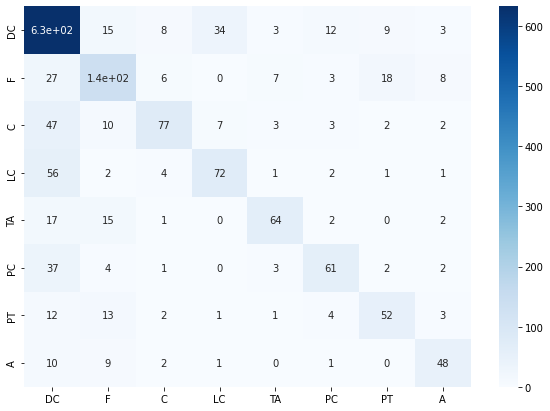

In [99]:
y_pred = model.predict(np.array([list(v) for v in test.vecs]))
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

cr = classification_report(y_test, y_pred, target_names=['DC','F','C','LC','TA','PC','PT','A'])
print(cr)
     
cm = confusion_matrix(y_test, y_pred)
print(cm)
cm = pd.DataFrame(cm)
cm.index=(['DC','F','C','LC','TA','PC','PT','A'])
cm.columns=(['DC','F','C','LC','TA','PC','PT','A'])

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, cmap='Blues')


In [18]:
model.save('model_aug.h5')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_12 (Dropout)        (None, 10000)             0         
                                                                 
 gaussian_noise_4 (GaussianN  (None, 10000)            0         
 oise)                                                           
                                                                 
 dense_27 (Dense)            (None, 1024)              10241024  
                                                                 
 dense_28 (Dense)            (None, 512)               524800    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_29 (Dense)            (None, 128)               65664     
                                                      

Epoch 19/100
6327/6327 [==============================] - 99s 16ms/step - loss: 0.4531 - accuracy: 0.9713 - precision: 0.9233 - recall: 0.8406 - auc: 0.9847 - f1_score: 0.8736 - val_loss: 1.6643 - val_accuracy: 0.9294 - val_precision: 0.7436 - val_recall: 0.6637 - val_auc: 0.8997 - val_f1_score: 0.6978
Epoch 20/100
6327/6327 [==============================] - 99s 16ms/step - loss: 0.4877 - accuracy: 0.9692 - precision: 0.9170 - recall: 0.8285 - auc: 0.9831 - f1_score: 0.8637 - val_loss: 1.3897 - val_accuracy: 0.9277 - val_precision: 0.7632 - val_recall: 0.6113 - val_auc: 0.9074 - val_f1_score: 0.6679
Epoch 21/100
6327/6327 [==============================] - 99s 16ms/step - loss: 0.4745 - accuracy: 0.9699 - precision: 0.9190 - recall: 0.8323 - auc: 0.9837 - f1_score: 0.8671 - val_loss: 1.6084 - val_accuracy: 0.9285 - val_precision: 0.7434 - val_recall: 0.6536 - val_auc: 0.9079 - val_f1_score: 0.6902
Epoch 22/100
6327/6327 [==============================] - 100s 16ms/step - loss: 0.4686 

6327/6327 [==============================] - 85s 13ms/step - loss: 0.3852 - accuracy: 0.9769 - precision: 0.9405 - recall: 0.8699 - auc: 0.9886 - f1_score: 0.8988 - val_loss: 1.6734 - val_accuracy: 0.9309 - val_precision: 0.7584 - val_recall: 0.6568 - val_auc: 0.9003 - val_f1_score: 0.6948
Epoch 70/100
6327/6327 [==============================] - 85s 13ms/step - loss: 0.4041 - accuracy: 0.9763 - precision: 0.9409 - recall: 0.8645 - auc: 0.9878 - f1_score: 0.8952 - val_loss: 1.5233 - val_accuracy: 0.9319 - val_precision: 0.7731 - val_recall: 0.6441 - val_auc: 0.9077 - val_f1_score: 0.6934
Epoch 71/100
6327/6327 [==============================] - 85s 13ms/step - loss: 0.3870 - accuracy: 0.9764 - precision: 0.9416 - recall: 0.8653 - auc: 0.9888 - f1_score: 0.8960 - val_loss: 1.6945 - val_accuracy: 0.9330 - val_precision: 0.7581 - val_recall: 0.6814 - val_auc: 0.9022 - val_f1_score: 0.7113
Epoch 72/100
6327/6327 [==============================] - 85s 13ms/step - loss: 0.3740 - accuracy: 0.

<AxesSubplot:>

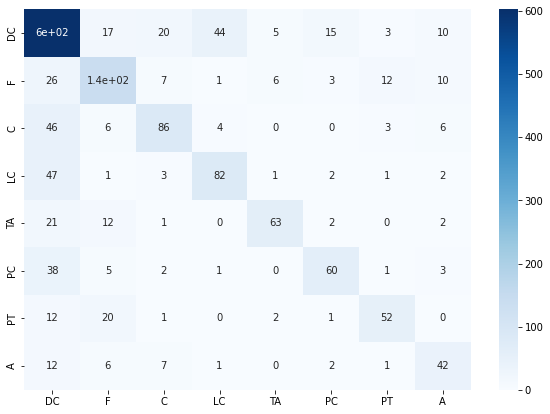

In [17]:

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

# model = tf.keras.models.load_model('model_aug.h5')
model = keras.models.load_model('model_aug.h5' , custom_objects={"f1_score": f1_score })

model.summary()

train = pd.read_parquet('10K_aug_norm.gzip')    
test = pd.read_parquet('10K_aug_norm_test.gzip')    

y_train = tf.keras.utils.to_categorical(np.array(train.labels).reshape(-1,1), num_classes=len(set(train.labels)))
y_test = tf.keras.utils.to_categorical(np.array(test.labels).reshape(-1,1), num_classes=len(set(test.labels)))


history = model.fit(np.array([list(v) for v in train.vecs]), np.array(y_train),
                    validation_data=(np.array([list(v) for v in test.vecs]), np.array(y_test)), epochs = 100,batch_size=4, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_accuracy",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)

y_pred = model.predict(np.array([list(v) for v in test.vecs]))
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

cr = classification_report(y_test, y_pred, target_names=['DC','F','C','LC','TA','PC','PT','A'])
print(cr)
     
cm = confusion_matrix(y_test, y_pred)
print(cm)
cm = pd.DataFrame(cm)
cm.index=(['DC','F','C','LC','TA','PC','PT','A'])
cm.columns=(['DC','F','C','LC','TA','PC','PT','A'])

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, cmap='Blues')


In [31]:
df
df_test

,vecs,labels
0,"[-0.2897914, -0.007478118, -0.36546326, -0.247...",7
1,"[-0.33007467, -0.11365177, -0.3280609, -0.1938...",1
2,"[-0.1695535, -0.04495229, -0.3481422, -0.18562...",0
3,"[-0.1665232, -0.17346199, -0.38861987, -0.1683...",3
4,"[-0.20286801, -0.11580123, -0.4215308, -0.0983...",5
...,...,...
1577,"[-0.3012898, -0.072665185, -0.24867663, -0.275...",0
1578,"[-0.26185262, -0.23114567, -0.4565281, -0.2795...",1
1579,"[-0.3773674, -0.08070058, -0.55280465, -0.4148...",0
1580,"[-0.24400455, -0.2331514, -0.22321974, -0.1408...",0


In [39]:

# train = pd.read_parquet('10K_aug_norm.gzip')    
# test = pd.read_parquet('10K_aug_norm_test.gzip')    

train = df
test = df_test

y_train = tf.keras.utils.to_categorical(np.array(train.labels).reshape(-1,1), num_classes=len(set(train.labels)))
y_test = tf.keras.utils.to_categorical(np.array(test.labels).reshape(-1,1), num_classes=len(set(test.labels)))



In [41]:



model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(10000,),))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
# model.add(tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(256, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer='l1_l2',kernel_initializer=tf.keras.initializers.HeNormal())),
model.add(tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l1_l2',kernel_initializer=tf.keras.initializers.HeNormal())),
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(64, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(64, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(32, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(8, activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()


opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)#'Adam'

history = model.fit(np.array([list(v) for v in train.vecs]), np.array(y_train),
                    validation_data=(np.array([list(v) for v in test.vecs]), np.array(y_test)), epochs = 500,batch_size=8, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)

y_pred = model.predict(np.array([list(v) for v in test.vecs]))
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

cr = classification_report(y_test, y_pred, target_names=['DC','F','C','LC','TA','PC','PT','A'])
print(cr)
     
cm = confusion_matrix(y_test, y_pred)
print(cm)
cm = pd.DataFrame(cm)
cm.index=(['DC','F','C','LC','TA','PC','PT','A'])
cm.columns=(['DC','F','C','LC','TA','PC','PT','A'])

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, cmap='Blues')


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_30 (Dropout)        (None, 10000)             0         
                                                                 
 gaussian_noise_10 (Gaussian  (None, 10000)            0         
 Noise)                                                          
                                                                 
 dense_94 (Dense)            (None, 512)               5120512   
                                                                 
 dense_95 (Dense)            (None, 512)               262656    
                                                                 
 dense_96 (Dense)            (None, 512)               262656    
                                                                 
 dense_97 (Dense)            (None, 256)               131328    
                                                     

Epoch 45/500
3164/3164 [==============================] - 54s 17ms/step - loss: 0.9578 - accuracy: 0.9405 - precision: 0.8394 - recall: 0.6479 - auc: 0.9606 - f1_score: 0.7242 - val_loss: 1.6787 - val_accuracy: 0.9149 - val_precision: 0.6909 - val_recall: 0.5777 - val_auc: 0.8981 - val_f1_score: 0.6250
Epoch 46/500
3164/3164 [==============================] - 54s 17ms/step - loss: 0.9390 - accuracy: 0.9425 - precision: 0.8443 - recall: 0.6619 - auc: 0.9616 - f1_score: 0.7351 - val_loss: 1.6918 - val_accuracy: 0.9103 - val_precision: 0.6849 - val_recall: 0.5234 - val_auc: 0.8962 - val_f1_score: 0.5880
Epoch 47/500
3164/3164 [==============================] - 54s 17ms/step - loss: 0.9549 - accuracy: 0.9428 - precision: 0.8449 - recall: 0.6644 - auc: 0.9607 - f1_score: 0.7367 - val_loss: 1.9146 - val_accuracy: 0.9106 - val_precision: 0.6697 - val_recall: 0.5626 - val_auc: 0.8938 - val_f1_score: 0.6080
Epoch 48/500
3164/3164 [==============================] - 54s 17ms/step - loss: 0.9555 -

Epoch 72/500
3164/3164 [==============================] - 54s 17ms/step - loss: 0.7716 - accuracy: 0.9632 - precision: 0.8878 - recall: 0.8077 - auc: 0.9773 - f1_score: 0.8424 - val_loss: 2.4811 - val_accuracy: 0.9129 - val_precision: 0.6657 - val_recall: 0.6094 - val_auc: 0.8905 - val_f1_score: 0.6342
Epoch 73/500
3164/3164 [==============================] - 54s 17ms/step - loss: 0.7847 - accuracy: 0.9629 - precision: 0.8881 - recall: 0.8049 - auc: 0.9766 - f1_score: 0.8414 - val_loss: 2.1520 - val_accuracy: 0.9173 - val_precision: 0.6804 - val_recall: 0.6378 - val_auc: 0.8895 - val_f1_score: 0.6559
Epoch 74/500
3164/3164 [==============================] - 57s 18ms/step - loss: 0.7426 - accuracy: 0.9639 - precision: 0.8904 - recall: 0.8112 - auc: 0.9771 - f1_score: 0.8466 - val_loss: 1.7775 - val_accuracy: 0.9194 - val_precision: 0.7033 - val_recall: 0.6144 - val_auc: 0.8970 - val_f1_score: 0.6532
Epoch 75/500
3164/3164 [==============================] - 64s 20ms/step - loss: 0.7192 -

Epoch 99/500
3164/3164 [==============================] - 55s 17ms/step - loss: 1.0634 - accuracy: 0.9562 - precision: 0.8826 - recall: 0.7491 - auc: 0.9668 - f1_score: 0.7982 - val_loss: 1.9990 - val_accuracy: 0.9186 - val_precision: 0.6893 - val_recall: 0.6353 - val_auc: 0.8936 - val_f1_score: 0.6599
Epoch 100/500
3164/3164 [==============================] - 55s 17ms/step - loss: 0.9723 - accuracy: 0.9634 - precision: 0.8856 - recall: 0.8122 - auc: 0.9748 - f1_score: 0.8443 - val_loss: 2.2770 - val_accuracy: 0.9093 - val_precision: 0.6472 - val_recall: 0.6030 - val_auc: 0.8776 - val_f1_score: 0.6230
Epoch 101/500
3164/3164 [==============================] - 56s 18ms/step - loss: 0.9600 - accuracy: 0.9571 - precision: 0.8713 - recall: 0.7710 - auc: 0.9704 - f1_score: 0.8140 - val_loss: 1.7729 - val_accuracy: 0.9185 - val_precision: 0.6870 - val_recall: 0.6397 - val_auc: 0.8894 - val_f1_score: 0.6615
Epoch 102/500
3164/3164 [==============================] - 55s 17ms/step - loss: 0.803

Epoch 126/500
3164/3164 [==============================] - 57s 18ms/step - loss: 0.7511 - accuracy: 0.9671 - precision: 0.8931 - recall: 0.8367 - auc: 0.9770 - f1_score: 0.8620 - val_loss: 1.7967 - val_accuracy: 0.9219 - val_precision: 0.7043 - val_recall: 0.6473 - val_auc: 0.8901 - val_f1_score: 0.6725
Epoch 127/500
3164/3164 [==============================] - 57s 18ms/step - loss: 0.7018 - accuracy: 0.9701 - precision: 0.9055 - recall: 0.8496 - auc: 0.9810 - f1_score: 0.8748 - val_loss: 1.8151 - val_accuracy: 0.9165 - val_precision: 0.6809 - val_recall: 0.6245 - val_auc: 0.8984 - val_f1_score: 0.6496
Epoch 128/500
3164/3164 [==============================] - 57s 18ms/step - loss: 0.7974 - accuracy: 0.9648 - precision: 0.8816 - recall: 0.8295 - auc: 0.9756 - f1_score: 0.8529 - val_loss: 1.7177 - val_accuracy: 0.9106 - val_precision: 0.6527 - val_recall: 0.6094 - val_auc: 0.8796 - val_f1_score: 0.6296
Epoch 129/500
3164/3164 [==============================] - 57s 18ms/step - loss: 1.04

Epoch 153/500
3164/3164 [==============================] - 60s 19ms/step - loss: 0.7080 - accuracy: 0.9622 - precision: 0.8765 - recall: 0.8121 - auc: 0.9803 - f1_score: 0.8406 - val_loss: 1.6874 - val_accuracy: 0.9106 - val_precision: 0.6614 - val_recall: 0.5841 - val_auc: 0.8940 - val_f1_score: 0.6181
Epoch 154/500
3164/3164 [==============================] - 60s 19ms/step - loss: 0.7934 - accuracy: 0.9620 - precision: 0.8807 - recall: 0.8054 - auc: 0.9796 - f1_score: 0.8381 - val_loss: 1.8343 - val_accuracy: 0.9160 - val_precision: 0.6798 - val_recall: 0.6201 - val_auc: 0.8812 - val_f1_score: 0.6469
Epoch 155/500
3164/3164 [==============================] - 60s 19ms/step - loss: 0.7857 - accuracy: 0.9615 - precision: 0.8773 - recall: 0.8049 - auc: 0.9795 - f1_score: 0.8367 - val_loss: 1.9545 - val_accuracy: 0.9117 - val_precision: 0.6557 - val_recall: 0.6188 - val_auc: 0.8858 - val_f1_score: 0.6359
Epoch 156/500
3164/3164 [==============================] - 60s 19ms/step - loss: 0.75

Epoch 180/500
3164/3164 [==============================] - 61s 19ms/step - loss: 0.6529 - accuracy: 0.9778 - precision: 0.9373 - recall: 0.8816 - auc: 0.9887 - f1_score: 0.9064 - val_loss: 2.2572 - val_accuracy: 0.9268 - val_precision: 0.7247 - val_recall: 0.6688 - val_auc: 0.8854 - val_f1_score: 0.6938
Epoch 181/500
3164/3164 [==============================] - 61s 19ms/step - loss: 0.5408 - accuracy: 0.9825 - precision: 0.9505 - recall: 0.9075 - auc: 0.9904 - f1_score: 0.9269 - val_loss: 2.2619 - val_accuracy: 0.9276 - val_precision: 0.7293 - val_recall: 0.6694 - val_auc: 0.8965 - val_f1_score: 0.6963
Epoch 182/500
3164/3164 [==============================] - 60s 19ms/step - loss: 1.1140 - accuracy: 0.9610 - precision: 0.8934 - recall: 0.7809 - auc: 0.9786 - f1_score: 0.8250 - val_loss: 2.1289 - val_accuracy: 0.9187 - val_precision: 0.6913 - val_recall: 0.6315 - val_auc: 0.8867 - val_f1_score: 0.6582
Epoch 183/500
3164/3164 [==============================] - 59s 19ms/step - loss: 0.67

Epoch 207/500
3164/3164 [==============================] - 57s 18ms/step - loss: 0.8710 - accuracy: 0.9593 - precision: 0.8585 - recall: 0.8076 - auc: 0.9719 - f1_score: 0.8306 - val_loss: 1.9699 - val_accuracy: 0.9173 - val_precision: 0.6809 - val_recall: 0.6365 - val_auc: 0.8832 - val_f1_score: 0.6559
Epoch 208/500
3164/3164 [==============================] - 57s 18ms/step - loss: 0.8464 - accuracy: 0.9632 - precision: 0.8745 - recall: 0.8240 - auc: 0.9733 - f1_score: 0.8466 - val_loss: 1.7814 - val_accuracy: 0.9200 - val_precision: 0.6966 - val_recall: 0.6372 - val_auc: 0.8866 - val_f1_score: 0.6630
Epoch 209/500
3164/3164 [==============================] - 57s 18ms/step - loss: 0.8101 - accuracy: 0.9643 - precision: 0.8832 - recall: 0.8233 - auc: 0.9758 - f1_score: 0.8499 - val_loss: 1.6978 - val_accuracy: 0.9232 - val_precision: 0.7103 - val_recall: 0.6511 - val_auc: 0.8907 - val_f1_score: 0.6779
Epoch 210/500
3164/3164 [==============================] - 68s 21ms/step - loss: 0.94

KeyboardInterrupt: 

In [ ]:

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(10000,),))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
# model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(64, activation='relu'))#, kernel_regularizer='l1_l2')),
# model.add(tf.keras.layers.Dense(32, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(8, activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()



opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)#'Adam'

history = model.fit(np.array([list(v) for v in train.vecs]), np.array(y_train),
                    validation_data=(np.array([list(v) for v in test.vecs]), np.array(y_test)), epochs = 500,batch_size=2, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)

y_pred = model.predict(np.array([list(v) for v in test.vecs]))
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

cr = classification_report(y_test, y_pred, target_names=['DC','F','C','LC','TA','PC','PT','A'])
print(cr)
     
cm = confusion_matrix(y_test, y_pred)
print(cm)
cm = pd.DataFrame(cm)
cm.index=(['DC','F','C','LC','TA','PC','PT','A'])
cm.columns=(['DC','F','C','LC','TA','PC','PT','A'])

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, cmap='Blues')


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_42 (Dropout)        (None, 10000)             0         
                                                                 
 gaussian_noise_14 (Gaussian  (None, 10000)            0         
 Noise)                                                          
                                                                 
 dense_124 (Dense)           (None, 1024)              10241024  
                                                                 
 dense_125 (Dense)           (None, 512)               524800    
                                                                 
 dropout_43 (Dropout)        (None, 512)               0         
                                                                 
 dense_126 (Dense)           (None, 128)               65664     
                                                     

Epoch 47/500
12654/12654 [==============================] - 179s 14ms/step - loss: 0.8433 - accuracy: 0.9470 - precision: 0.8777 - recall: 0.6688 - auc: 0.9522 - f1_score: 0.7217 - val_loss: 1.4209 - val_accuracy: 0.9239 - val_precision: 0.7821 - val_recall: 0.5424 - val_auc: 0.9056 - val_f1_score: 0.5952
Epoch 48/500
12654/12654 [==============================] - 179s 14ms/step - loss: 0.8334 - accuracy: 0.9463 - precision: 0.8802 - recall: 0.6601 - auc: 0.9538 - f1_score: 0.7150 - val_loss: 1.3385 - val_accuracy: 0.9274 - val_precision: 0.7931 - val_recall: 0.5670 - val_auc: 0.9081 - val_f1_score: 0.6195
Epoch 49/500
12654/12654 [==============================] - 178s 14ms/step - loss: 0.8587 - accuracy: 0.9465 - precision: 0.8760 - recall: 0.6667 - auc: 0.9533 - f1_score: 0.7194 - val_loss: 1.3652 - val_accuracy: 0.9251 - val_precision: 0.7877 - val_recall: 0.5487 - val_auc: 0.9012 - val_f1_score: 0.6026
Epoch 50/500
12654/12654 [==============================] - 160s 13ms/step - lo

Epoch 74/500
 7199/12654 [================>.............] - ETA: 1:11 - loss: 0.8247 - accuracy: 0.9491 - precision: 0.9052 - recall: 0.6618 - auc: 0.9550 - f1_score: 0.7218

In [3]:



train = pd.read_parquet('10k_2aug_norm.gzip')    
test = pd.read_parquet('10k_2aug_norm_test.gzip')    


y_train = tf.keras.utils.to_categorical(np.array(train.labels).reshape(-1,1), num_classes=len(set(train.labels)))
y_test = tf.keras.utils.to_categorical(np.array(test.labels).reshape(-1,1), num_classes=len(set(test.labels)))



model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(10000,),))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GaussianNoise(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1'))
model.add(tf.keras.layers.Dense(512, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(128, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(64, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dense(32, activation='relu'))#, kernel_regularizer='l1_l2')),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(8, activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal(),kernel_regularizer='l1_l2'))

model.summary()



opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)#'Adam'

history = model.fit(np.array([list(v) for v in train.vecs]), np.array(y_train),
                    validation_data=(np.array([list(v) for v in test.vecs]), np.array(y_test)), epochs = 500,batch_size=16, callbacks=[tf.keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/breast_cancer_detection/ckeckpoint', monitor="val_f1_score",    verbose=0,    save_best_only=True,
            save_weights_only=False,    mode="auto",    save_freq="epoch",)])#,class_weight=classWeight)#, batch_size = 32)

y_pred = model.predict(np.array([list(v) for v in test.vecs]))
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

cr = classification_report(y_test, y_pred, target_names=['DC','F','C','LC','TA','PC','PT','A'])
print(cr)
     
cm = confusion_matrix(y_test, y_pred)
print(cm)
cm = pd.DataFrame(cm)
cm.index=(['DC','F','C','LC','TA','PC','PT','A'])
cm.columns=(['DC','F','C','LC','TA','PC','PT','A'])

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, cmap='Blues')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 10000)             0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 10000)            0         
 se)                                                             
                                                                 
 dense (Dense)               (None, 1024)              10241024  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                        

KeyboardInterrupt: 

In [8]:
(test.iloc[0][0]).shape

(151296,)

In [4]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


model = keras.models.load_model('model_2080_2_aug3.h5',custom_objects={"f1_score":f1_score})
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_12 (Dropout)        (None, 10000)             0         
                                                                 
 gaussian_noise_4 (GaussianN  (None, 10000)            0         
 oise)                                                           
                                                                 
 dense_28 (Dense)            (None, 1024)              10241024  
                                                                 
 dense_29 (Dense)            (None, 512)               524800    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_30 (Dense)            (None, 128)               65664     
                                                      

              precision    recall  f1-score   support

          DC       0.90      0.97      0.94       685
           F       0.92      0.89      0.90       190
           C       0.93      0.88      0.91       162
          LC       0.99      0.79      0.88       106
          TA       0.94      0.92      0.93       127
          PC       0.98      0.88      0.93       115
          PT       0.91      0.90      0.91       101
           A       0.93      0.91      0.92        96

    accuracy                           0.92      1582
   macro avg       0.94      0.89      0.91      1582
weighted avg       0.92      0.92      0.92      1582

[[667   4   6   1   4   1   0   2]
 [ 12 169   0   0   1   0   8   0]
 [ 14   1 143   0   0   1   0   3]
 [ 21   0   1  84   0   0   0   0]
 [  6   4   0   0 117   0   0   0]
 [ 10   0   1   0   1 101   1   1]
 [  4   4   1   0   0   0  91   1]
 [  5   2   1   0   1   0   0  87]]


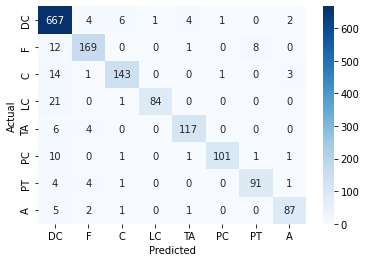

In [13]:

# y_pred = model.predict(np.array([list(v) for v in test.vecs]))
# y_pred=np.argmax(y_pred, axis=1)
# y_test=np.argmax(y_test, axis=1)

# cr = classification_report(y_test, y_pred, target_names=['DC','F','C','LC','TA','PC','PT','A'])
print(cr)
     
cm = confusion_matrix(y_test, y_pred)
print(cm)
cm = pd.DataFrame(cm)
cm.index=(['DC','F','C','LC','TA','PC','PT','A'])
cm.columns=(['DC','F','C','LC','TA','PC','PT','A'])

ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('heatmap.pdf')  

plt.show()
# plt.figure(figsize = (10,7))
# sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
